In [1]:
import os
import sys
import shutil

import logging
import re
import pathlib

import datetime

import numpy as np
import pandas as pd
from scipy.stats import pearsonr

import matplotlib.pyplot as plt

from pyplink import PyPlink
import seaborn as sns

import statsmodels.api as sm

import matplotlib.patches as patches
import matplotlib

from basic_tools import *

"""

jupyter nbconvert 5_association.ipynb --to script
python 5_association.py albumin 2 0

"""

'\n\njupyter nbconvert 5_association.ipynb --to script\npython 5_association.py albumin 2 0\n\n'

In [2]:
plink_KCHIP_HLA_AA_SNP_1000G=PyPlink(plink_KCHIP_HLA_AA_SNP_1000G_path)
plink_KCHIP_HLA_AA_SNP_1000G_fam=plink_KCHIP_HLA_AA_SNP_1000G.get_fam().astype({'fid':str,'iid':str}).rename(columns={'fid':'FID','iid':'IID'})
plink_KCHIP_HLA_AA_SNP_1000G_bim=plink_KCHIP_HLA_AA_SNP_1000G.get_bim()

In [3]:
phenotype_info=pd.read_csv('data/phenotype_pubname.tsv',sep='\t',index_col=0)

In [4]:
phenotypes=pd.read_csv(pheno_all_file_path,sep='\t')
phenotypes=phenotypes.set_index('ID').loc[plink_KCHIP_HLA_AA_SNP_1000G_fam['IID']]

binary_continuous_traits=phenotypes.columns.difference(['age','sex','cohort','diabetes'])
print(len(binary_continuous_traits))

97


In [10]:
binary_continuous_traits_filtered=[]
for phenotype_name in binary_continuous_traits:
    data_out_assoc_phenotype_path=data_out_assoc_path+phenotype_name+'/'
    pheno=pd.read_csv(data_out_pheno_path+phenotype_name+'.phe',sep='\t',names=['FID','IID','pheno'])
    
    num_data=(pheno['pheno']!=-9).sum()
    if num_data<10000:
        print(phenotype_name,num_data,'excluded')
    else:
        binary_continuous_traits_filtered.append(phenotype_name)
        
print(len(binary_continuous_traits_filtered))        
binary_continuous_traits=binary_continuous_traits_filtered

FEV_over_FVC_predicted 7440 excluded
FEV_predicted 7440 excluded
FVC_predicted 7441 excluded
MVV_predicted 7441 excluded
bone_density_distal_sos 7242 excluded
bone_density_midshaft_sos 7261 excluded
child_dead 3934 excluded
child_present 3843 excluded
freet4 284 excluded
insomnia 5148 excluded
peripheral_vascular_diseases 4509 excluded
renin 7500 excluded
rheumatoid_arthritis 4876 excluded
sleep_duration 7480 excluded
tsh 286 excluded
82


In [125]:
gene_bed_path='data/mart_export_grch37.txt'
gene_bed=pd.read_csv(gene_bed_path,sep='\t')
gene_bed=gene_bed.drop(columns='Exon stable ID')
gene_bed=gene_bed[(gene_bed['Gene start (bp)']>=plink_KCHIP_HLA_AA_SNP_1000G_bim.pos.min())&(gene_bed['Gene end (bp)']<=plink_KCHIP_HLA_AA_SNP_1000G_bim.pos.max())]
gene_bed=gene_bed[(gene_bed['Transcript type']=='protein_coding')]
gene_bed=gene_bed[~gene_bed.duplicated(['Gene name','Gene start (bp)','Gene end (bp)'])]
print(gene_bed.shape)
gene_bed=gene_bed[~gene_bed.duplicated(['Gene name'])]
print(gene_bed.shape)

gene_assign=plink_KCHIP_HLA_AA_SNP_1000G_bim[['pos']]

for idx,row in gene_bed.iterrows():
    gene_assign[row['Gene name']]=0
    
for idx,row in gene_bed.iterrows():    
    gene_assign[row['Gene name']][(gene_assign['pos']>=row['Gene start (bp)'])&(gene_assign['pos']<=row['Gene end (bp)'])]=1

#gene_assign.columns=gene_assign.columns.str.replace('HLA-','HLA_')        
    
HLA_names=np.unique([i[0].split('_')[1] for i in plink_KCHIP_HLA_AA_SNP_1000G_bim[plink_KCHIP_HLA_AA_SNP_1000G_bim.index.str.contains('HLA_')].index.str.split('*')])

for HLA_name in HLA_names:
    gene_select=gene_assign[gene_assign.index.str.contains('HLA_'+HLA_name)|gene_assign.index.str.contains('SNPS_'+HLA_name)|gene_assign.index.str.contains('AA_'+HLA_name)]#print(gene_select.sort_values('pos').iloc[0],gene_select.sort_values('pos').iloc[-1])
    HLA_name='HLA-{}'.format(HLA_name)
    gene_assign[HLA_name][(gene_assign['pos']>=gene_select['pos'].min())&(gene_assign['pos']<=gene_select['pos'].max())]=1 

(209, 30)
(207, 30)


/home/ch6845/tools/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


# conversion manual

In [22]:
conversion_manual=pd.read_csv(conversion_manual_path,sep='\t')
conversion_manual=conversion_manual[~conversion_manual['phenotype_code'].isnull()]
conversion_manual.head()

,phenotype_code,commands
0,NC1_AGE,age@(x!=66666)&(x!=77777)&(x!=99999)@x
1,CT1_AGE,age@(x!=66666)&(x!=77777)&(x!=99999)@x
2,AS1_AGE,age@(x!=66666)&(x!=77777)&(x!=99999)@x
4,NC1_SEX,sex@1@1|sex@2@2
5,CT1_SEX,sex@1@1|sex@2@2


In [ ]:
conversion_manual_pub=conversion_manual.copy()
conversion_manual_pub['phenotype_name']=[i[0] for i in conversion_manual_pub['commands'].str.split('@')]
#conversion_manual_pub['phenotype_name_publication']=conversion_manual_pub['phenotype_name']


conversion_manual_pub['phenotype_type']=phenotype_info.loc[conversion_manual_pub['phenotype_name']]['phenotype_type'].values
conversion_manual_pub['phenotype_category']=phenotype_info.loc[conversion_manual_pub['phenotype_name']]['phenotype_category'].values
conversion_manual_pub['phenotype_name_publication']=phenotype_info.loc[conversion_manual_pub['phenotype_name']]['phenotype_name_publication'].values

for idx,row in phenotype_info.iterrows():
    conversion_manual_pub['commands']=conversion_manual_pub['commands'].str.replace(idx+'@','if it is ')
    #conversion_manual_pub['phenotype_name_publication']=conversion_manual_pub['phenotype_name_publication'].str.replace(idx,row['phenotype_name_publication'])
    #conversion_manual_pub['commands']=conversion_manual_pub['commands'].str.replace(row['phenotype_name_publication']+'@',''+row['phenotype_name_publication']+'  <-    if ')
    
for idx,row in phenotype_info.iterrows():    
    
    conversion_manual_pub['commands']=conversion_manual_pub['commands'].str.replace('@',', save as ',regex=False)
    conversion_manual_pub['commands']=conversion_manual_pub['commands'].str.replace('+','it contains ',regex=False)
    
    #conversion_manual_pub['commands']=conversion_manual_pub['commands'].str.replace('|',' , ')
    #conversion_manual_pub['commands']=conversion_manual_pub['commands'].str.replace('&',' and ')

In [353]:
conversion_manual_pub=conversion_manual_pub[conversion_manual_pub['phenotype_name'].apply(lambda x: x in binary_continuous_traits)]

In [354]:
len(conversion_manual_pub['phenotype_name_publication'].unique())

81

In [355]:
len(binary_continuous_traits)

82

In [356]:
set(binary_continuous_traits).difference(conversion_manual_pub['phenotype_name'].unique())

{'bmi'}

In [357]:
conversion_manual_pub[conversion_manual_pub['phenotype_category']=='Other QTL']

,phenotype_code,commands,phenotype_name,phenotype_type,phenotype_category,phenotype_name_publication
186,NC1_PWI,"if it is (x!=66666)&(x!=77777)&(x!=99999), sav...",pwi_total,continuous,Other QTL,Personal Well-being Index
187,CT1_PWI,"if it is (x!=66666)&(x!=77777)&(x!=99999), sav...",pwi_total,continuous,Other QTL,Personal Well-being Index
232,NC1_PULSE1,"if it is (x!=66666)&(x!=77777)&(x!=99999), sav...",pulse,continuous,Other QTL,Pulse rate
233,CT1_PULSE,"if it is (x!=66666)&(x!=77777)&(x!=99999), sav...",pulse,continuous,Other QTL,Pulse rate
234,AS1_PLLIE1,"if it is (x!=66666)&(x!=77777)&(x!=99999), sav...",pulse,continuous,Other QTL,Pulse rate
239,NC1_MNSAG,"if it is (x!=66666)&(x!=77777)&(x!=99999), sav...",menarche_onset_age,continuous,Other QTL,Menarche onset age
240,CT1_MNSAG,"if it is (x!=66666)&(x!=77777)&(x!=99999), sav...",menarche_onset_age,continuous,Other QTL,Menarche onset age
241,AS1_MNSAG,"if it is (x!=66666)&(x!=77777)&(x!=99999), sav...",menarche_onset_age,continuous,Other QTL,Menarche onset age
243,NC1_PMAG,"if it is (x!=66666)&(x!=77777)&(x!=99999), sav...",menopause_age,continuous,Other QTL,Menopause age
244,CT1_PMAG,"if it is (x!=66666)&(x!=77777)&(x!=99999), sav...",menopause_age,continuous,Other QTL,Menopause age


In [358]:
len(conversion_manual_pub[conversion_manual_pub['phenotype_type']=='binary']['phenotype_name'].unique()),\
len(conversion_manual_pub[conversion_manual_pub['phenotype_type']=='continuous']['phenotype_name'].unique()),

(47, 34)

In [368]:
len(phenotype_info),\
len(phenotype_info.loc[binary_continuous_traits]),\
len(phenotype_info.loc[binary_continuous_traits][phenotype_info.loc[binary_continuous_traits]['phenotype_type']=='binary']),\
len(phenotype_info.loc[binary_continuous_traits][phenotype_info.loc[binary_continuous_traits]['phenotype_type']=='continuous']),\

(98, 82, 47, 35)

In [366]:
phenotype_info.loc[binary_continuous_traits]['phenotype_type']

phenotype_name
acute_liver_disease                          binary
albumin                                  continuous
allergic_disease                             binary
alt                                      continuous
angina_pectoris_myocardial_infarction        binary
arthritis                                    binary
ast                                      continuous
asthma                                       binary
benign_prostatic_hyperplasia                 binary
big_baby                                     binary
bladder_cancer                               binary
blood_in_urine                               binary
bmi                                      continuous
breast_cancer                                binary
bun                                      continuous
cataract                                     binary
cervical_cancer                              binary
child_delivery_number                    continuous
cholelithiasis_cholecystitis                 bina

In [ ]:
len(conversion_manual_pub[conversion_manual_pub['phenotype_type']=='binary']['phenotype_name'].unique()),\

In [359]:
conversion_manual_pub.head()

,phenotype_code,commands,phenotype_name,phenotype_type,phenotype_category,phenotype_name_publication
8,NC1_ASTH,"if it is 2, save as 2",asthma,binary,Immune-related disease,Asthma
9,CT1_ASTH,"if it is 2, save as 2",asthma,binary,Immune-related disease,Asthma
10,AS1_PDAS,"if it is 2, save as 2",asthma,binary,Immune-related disease,Asthma
11,AS1_TRTAS,"if it is 2, save as 2",asthma,binary,Immune-related disease,Asthma
13,NC1_BRON,"if it is 2, save as 2",chronic_bronchitis,binary,Other disease,Chronic bronchitis


In [45]:
conversion_manual_pub\
[['phenotype_code','commands','phenotype_name_publication']]\
.rename(columns={'phenotype_code':'KoGES code',
                 'commands':'conditon',
                 'phenotype_name_publication':'Phenotype name'
               }).to_csv(data_out_pub_path+'KoGES_phenotype.tsv',sep='\t',encoding='euc-kr')

# marker information

In [46]:
plink_KCHIP_HLA_AA_SNP_1000G_fam.shape

(125673, 6)

## KCHIP original

In [47]:
plink_KCHIP_original=PyPlink('data/genotype/1_KCHIP_unimputed/KCHIP_original/KCHIP_HLA')
plink_KCHIP_original_fam=plink_KCHIP_original.get_fam().astype({'fid':str,'iid':str}).rename(columns={'fid':'FID','iid':'IID'})
plink_KCHIP_original_bim=plink_KCHIP_original.get_bim()

In [48]:
plink_KCHIP_original_bim.shape

(5292, 5)

## KCHIP imputed

In [49]:
#plink_KCHIP_original=PyPlink('data/genotype/0_1000G/KCHIP_HLA_6_28Mb_35Mb_20200113_QC.recode.newQC.nooverlap')
plink_KCHIP_HLA_AA_SNP=PyPlink('data/genotype/3_KCHIP_bmarkerphased/KCHIP_HLA_hg19.bMarker.QC')
plink_KCHIP_HLA_AA_SNP_fam=plink_KCHIP_HLA_AA_SNP.get_fam().astype({'fid':str,'iid':str}).rename(columns={'fid':'FID','iid':'IID'})
plink_KCHIP_HLA_AA_SNP_bim=plink_KCHIP_HLA_AA_SNP.get_bim()

In [50]:
marker_all=plink_KCHIP_HLA_AA_SNP_bim[:].copy()
marker_HLA=plink_KCHIP_HLA_AA_SNP_bim[plink_KCHIP_HLA_AA_SNP_bim.index.str.contains('HLA_')].copy()
marker_AA=plink_KCHIP_HLA_AA_SNP_bim[plink_KCHIP_HLA_AA_SNP_bim.index.str.contains('AA_')].copy()
marker_SNP=marker_all.loc[marker_all.index.difference(marker_HLA.index).difference(marker_AA.index)]

In [51]:
#marker_SNP
a=marker_SNP[marker_SNP.index.str.startswith('SNP')]
a.shape,a[~a.duplicated('pos')].shape

((8276, 5), (5969, 5))

In [52]:
a=marker_SNP[marker_SNP.index.str.startswith('INS_SNP')]
a.shape,a[~a.duplicated('pos')].shape

((130, 5), (130, 5))

In [53]:
marker_AA.shape,marker_AA[~marker_AA.duplicated('pos')].shape

((574, 5), (349, 5))

## 1000G

In [54]:
#plink_KCHIP_original=PyPlink('data/genotype/0_1000G/KCHIP_HLA_6_28Mb_35Mb_20200113_QC.recode.newQC.nooverlap')
plink_KCHIP_1000G=PyPlink('data/genotype/4_merge/1000G')
plink_KCHIP_1000G_fam=plink_KCHIP_1000G.get_fam().astype({'fid':str,'iid':str}).rename(columns={'fid':'FID','iid':'IID'})
plink_KCHIP_1000G_bim=plink_KCHIP_1000G.get_bim()

In [55]:
marker_all=plink_KCHIP_1000G_bim[:].copy()

In [56]:
marker_all.shape

(56598, 5)

In [57]:
marker_all[~((marker_all['a1'].str.len()==1)&(marker_all['a2'].str.len()==1))].shape

(5357, 5)

In [58]:
marker_all[((marker_all['a1'].str.len()==1)&(marker_all['a2'].str.len()==1))].shape

(51241, 5)

## all

In [59]:
marker_all=plink_KCHIP_HLA_AA_SNP_1000G_bim[:].copy()
marker_HLA=plink_KCHIP_HLA_AA_SNP_1000G_bim[plink_KCHIP_HLA_AA_SNP_1000G_bim.index.str.contains('HLA_')].copy()
marker_AA=plink_KCHIP_HLA_AA_SNP_1000G_bim[plink_KCHIP_HLA_AA_SNP_1000G_bim.index.str.contains('AA_')].copy()
marker_SNP=marker_all.loc[marker_all.index.difference(marker_HLA.index).difference(marker_AA.index)]

In [60]:
marker_SNP.shape,marker_SNP[~marker_SNP.duplicated('pos')].shape

((70294, 5), (67276, 5))

In [61]:
119+349+13696

14164

In [62]:
56598+8276+130+5292

70296

In [63]:
67276

67276

In [64]:
#marker_all[marker_all['pos']>=33053550]

In [65]:
len(plink_KCHIP_HLA_AA_SNP_1000G_bim[plink_KCHIP_HLA_AA_SNP_1000G_bim.index.str.contains('HLA_')]['pos'].unique()),\
len(plink_KCHIP_HLA_AA_SNP_1000G_bim[plink_KCHIP_HLA_AA_SNP_1000G_bim.index.str.contains('AA_')]['pos'].unique()),\
len(plink_KCHIP_HLA_AA_SNP_1000G_bim['pos'].unique())

(8, 349, 67448)

# MAF

In [66]:
def cal_maf(dosage_array):
    maf=(1*(dosage_array==1).sum()+2*(dosage_array==2).sum())/\
         (2*(dosage_array!=-1).sum())
    return maf

maf_list_list=[]
for idx_bim,(SNP,row) in enumerate(plink_KCHIP_HLA_AA_SNP_1000G_bim[plink_KCHIP_HLA_AA_SNP_1000G_bim.index.str.contains('HLA_')].iterrows()):
    maf_list=[]
    assert row['a1']=='p'
    dosage=plink_KCHIP_HLA_AA_SNP_1000G.get_geno_marker(SNP)
    maf_list.append(cal_maf(dosage))
    for cohort in range(1,3+1):
        cohort_dosage=dosage[phenotypes['cohort']==cohort]
        #print('total: {:5d} -1:{:5d} 0:{:5d} 1:{:5d} 2:{:5d}'.format(len(cohort_dosage),(cohort_dosage==-1).sum(),(cohort_dosage==0).sum(),(cohort_dosage==1).sum(),(cohort_dosage==2).sum()))
        maf_list.append(cal_maf(cohort_dosage))
    
    maf_list_list.append(maf_list)

In [67]:
assert (phenotypes.index!=plink_KCHIP_HLA_AA_SNP_1000G_fam['IID']).sum()==0

In [68]:
maf_df=pd.DataFrame(maf_list_list,index=plink_KCHIP_HLA_AA_SNP_1000G_bim[plink_KCHIP_HLA_AA_SNP_1000G_bim.index.str.contains('HLA_')].index,columns=['all','AS','CT','NC'])

In [69]:
maf_df.index=maf_df.index.str.replace('_','-')

In [70]:
maf_df.head()

,all,AS,CT,NC
snp,,,,
HLA-A*01:01,0.017462,0.018733,0.017275,0.017930
HLA-A*02:01,0.164765,0.164454,0.163066,0.173798
HLA-A*02:06,0.086112,0.083081,0.086044,0.087692
HLA-A*02:07,0.034538,0.037465,0.034419,0.033982
HLA-A*03:01,0.015986,0.017878,0.015576,0.017375


In [71]:
maf_df.to_csv(data_out_pub_path+'HLA_allele_freq.tsv',sep='\t')

# GWAS each phenotype

In [73]:
for phenotype_name in binary_continuous_traits:
    data_out_assoc_phenotype_path=data_out_assoc_path+phenotype_name+'/'
    
    pheotype_name_publication=phenotype_info.loc[phenotype_name]['phenotype_name_publication'].replace(' ','_').replace('/','_')
    
    data_out_pub_phenotype_path=data_out_pub_path+pheotype_name_publication+'/'
    pathlib.Path(data_out_pub_phenotype_path).mkdir(parents=True, exist_ok=True)
    
    
    
    #pheno=pd.read_csv(data_out_pheno_path+phenotype_name+'.phe',sep='\t',names=['FID','IID','pheno'])
    #phenotype_type='binary' if len(pheno['pheno'][pheno['pheno']!=-9].value_counts())<3 else 'continuous'
    #phenotype_type    
    
    for step_idx_sub in range(1,100):
        print("phenotype_name: {}, phenotype_type:{} , Step : {} ".format(phenotype_name,'  ',step_idx_sub))
        #print(step_idx_sub)
        if os.path.exists(data_out_assoc_phenotype_path+'step_{:02d}.cond.stop'.format(step_idx_sub)):
            print('meets end',step_idx_sub)
            break
            
        result_merge=pd.read_csv(data_out_assoc_phenotype_path+'step_{:02d}.merge.result.tsv'.format(step_idx_sub),sep='\t',index_col=0)
        result_merge=result_merge.drop(columns=['phenotype_name'])  
        result_merge['phenotype_name_publication']=phenotype_info.loc[phenotype_name]['phenotype_name_publication']
        #print(result_merge.columns)
        
        result_merge[['phenotype_name_publication','phenotype_type', 'samples(case/control)', 'step', 'condition',
               'marker_name', 'marker_name_pub', 'note', 'term', 'POS', 'A1', 'A2',
               'A1_freq_case', 'A1_freq_control', 'multi_allele', 'nobs', 'Z', 'coef',
               'std', 'chisq', 'df', 'P']].to_csv(data_out_pub_phenotype_path+'step_{:02d}.result.tsv'.format(step_idx_sub),sep='\t',index=None)        
        
        shutil.copy(data_out_assoc_phenotype_path+'step_{:02d}.merge.manhattan.png'.format(step_idx_sub),
                    data_out_pub_phenotype_path+'step_{:02d}.manhattan.png'.format(step_idx_sub))         
        
        
        #break
    #break
        

phenotype_name: acute_liver_disease, phenotype_type:   , Step : 1 


/home/ch6845/tools/miniconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


phenotype_name: acute_liver_disease, phenotype_type:   , Step : 2 
meets end 2
phenotype_name: albumin, phenotype_type:   , Step : 1 
phenotype_name: albumin, phenotype_type:   , Step : 2 
phenotype_name: albumin, phenotype_type:   , Step : 3 
phenotype_name: albumin, phenotype_type:   , Step : 4 
phenotype_name: albumin, phenotype_type:   , Step : 5 
meets end 5
phenotype_name: allergic_disease, phenotype_type:   , Step : 1 
phenotype_name: allergic_disease, phenotype_type:   , Step : 2 
phenotype_name: allergic_disease, phenotype_type:   , Step : 3 
meets end 3
phenotype_name: alt, phenotype_type:   , Step : 1 
phenotype_name: alt, phenotype_type:   , Step : 2 
phenotype_name: alt, phenotype_type:   , Step : 3 
phenotype_name: alt, phenotype_type:   , Step : 4 
meets end 4
phenotype_name: angina_pectoris_myocardial_infarction, phenotype_type:   , Step : 1 
phenotype_name: angina_pectoris_myocardial_infarction, phenotype_type:   , Step : 2 
meets end 2
phenotype_name: arthritis, pheno

phenotype_name: mch, phenotype_type:   , Step : 2 
phenotype_name: mch, phenotype_type:   , Step : 3 
meets end 3
phenotype_name: mchc, phenotype_type:   , Step : 1 
phenotype_name: mchc, phenotype_type:   , Step : 2 
meets end 2
phenotype_name: mcv, phenotype_type:   , Step : 1 
phenotype_name: mcv, phenotype_type:   , Step : 2 
phenotype_name: mcv, phenotype_type:   , Step : 3 
phenotype_name: mcv, phenotype_type:   , Step : 4 
meets end 4
phenotype_name: menarche_onset_age, phenotype_type:   , Step : 1 
phenotype_name: menarche_onset_age, phenotype_type:   , Step : 2 
meets end 2
phenotype_name: menopause_age, phenotype_type:   , Step : 1 
phenotype_name: menopause_age, phenotype_type:   , Step : 2 
phenotype_name: menopause_age, phenotype_type:   , Step : 3 
meets end 3
phenotype_name: menopause_cycle, phenotype_type:   , Step : 1 
phenotype_name: menopause_cycle, phenotype_type:   , Step : 2 
meets end 2
phenotype_name: neurosis, phenotype_type:   , Step : 1 
phenotype_name: neuro

In [45]:
result_merge[result_merge['marker_name'].str.contains('HLA')]

,phenotype_type,samples(case/control),step,condition,marker_name,marker_name_pub,note,term,POS,A1,...,A1_freq_control,multi_allele,nobs,Z,coef,std,chisq,df,P,phenotype_name_publication
697,continuous,124693,5,"6:28861320_A/G,6:30990019_A/G,6:32569297_A/G,6...",HLA_A*30:04,HLA-A*30:04,phased biallelic,THIS,29910247,p,...,NaN,NaN,249386,0.055036,0.008058,0.146407,NaN,NaN,0.956110,Body Weight
743,continuous,124693,5,"6:28861320_A/G,6:30990019_A/G,6:32569297_A/G,6...",HLA_C*14:03,HLA-C*14:03,phased biallelic,THIS,29910247,p,...,NaN,NaN,249386,0.782039,0.060473,0.077327,NaN,NaN,0.434192,Body Weight
712,continuous,124693,5,"6:28861320_A/G,6:30990019_A/G,6:32569297_A/G,6...",HLA_B*38:02,HLA-B*38:02,phased biallelic,THIS,29910247,p,...,NaN,NaN,249386,-0.829307,-0.133654,0.161164,NaN,NaN,0.406931,Body Weight
711,continuous,124693,5,"6:28861320_A/G,6:30990019_A/G,6:32569297_A/G,6...",HLA_B*37:01,HLA-B*37:01,phased biallelic,THIS,29910247,p,...,NaN,NaN,249386,0.291615,0.049230,0.168819,NaN,NaN,0.770581,Body Weight
744,continuous,124693,5,"6:28861320_A/G,6:30990019_A/G,6:32569297_A/G,6...",HLA_C*15:02,HLA-C*15:02,phased biallelic,THIS,29910247,p,...,NaN,NaN,249386,0.926645,0.095257,0.102798,NaN,NaN,0.354111,Body Weight
709,continuous,124693,5,"6:28861320_A/G,6:30990019_A/G,6:32569297_A/G,6...",HLA_B*27:05,HLA-B*27:05,phased biallelic,THIS,29910247,p,...,NaN,NaN,249386,-1.198535,-0.127442,0.106332,NaN,NaN,0.230709,Body Weight
708,continuous,124693,5,"6:28861320_A/G,6:30990019_A/G,6:32569297_A/G,6...",HLA_B*15:18,HLA-B*15:18,phased biallelic,THIS,29910247,p,...,NaN,NaN,249386,1.221296,0.184437,0.151017,NaN,NaN,0.221974,Body Weight
707,continuous,124693,5,"6:28861320_A/G,6:30990019_A/G,6:32569297_A/G,6...",HLA_B*15:11,HLA-B*15:11,phased biallelic,THIS,29910247,p,...,NaN,NaN,249386,-0.476111,-0.056218,0.118078,NaN,NaN,0.633995,Body Weight
706,continuous,124693,5,"6:28861320_A/G,6:30990019_A/G,6:32569297_A/G,6...",HLA_B*15:07,HLA-B*15:07,phased biallelic,THIS,29910247,p,...,NaN,NaN,249386,0.551743,0.084341,0.152863,NaN,NaN,0.581124,Body Weight
705,continuous,124693,5,"6:28861320_A/G,6:30990019_A/G,6:32569297_A/G,6...",HLA_B*15:01,HLA-B*15:01,phased biallelic,THIS,29910247,p,...,NaN,NaN,249386,-1.787442,-0.106110,0.059364,NaN,NaN,0.073866,Body Weight


# Info

In [74]:
result_all=pd.read_csv('data/result_concat_2_top_gene_annot.tsv',sep='\t',index_col=1)

In [75]:
result_all_info=result_all.copy()

In [76]:
result_all_info['gene']=result_all_info['gene'].str.replace('RNF5,AGER','AGER').str.replace('C2,ZBTB12','C2')

In [77]:
result_all_info['phenotype_category']=phenotype_info.loc[result_all_info['phenotype_name']]['phenotype_category'].values
result_all_info['phenotype_name_publication']=phenotype_info.loc[result_all_info['phenotype_name']]['phenotype_name_publication'].values

assert np.all(result_all_info['phenotype_type']==phenotype_info.loc[result_all_info['phenotype_name']]['phenotype_type'].values)

In [78]:
result_all_info['A1 freq (cases, controls)']=result_all_info.apply(lambda x: '{:.3f}, {:.3f}'.format(x['A1_freq_case'],x['A1_freq_control']).replace(', nan','').replace('nan','-'), axis=1)

In [79]:
def marker_name_pub_prettify(marker_name_pub):
    if 'rs' in marker_name_pub:
        return marker_name_pub
    elif 'HLA' in marker_name_pub:
        return marker_name_pub
    elif '6:' in marker_name_pub:
        return marker_name_pub.split('_')[0]
    elif 'SNP' in marker_name_pub:
        return '6:'+marker_name_pub.split('_')[3]
    else:
        raise
#result_all_pub.apply(lambda x: x['marker_name_pub'] if 'rs' in x['marker_name_pub'] else ('aaaa',x['marker_name_pub']), axis=1)
result_all_info['marker_name_pub_prettify']=result_all_info['marker_name_pub'].apply(marker_name_pub_prettify)

In [80]:
result_all_info['A1/A2']=result_all_info.apply(lambda x: '{}/{}'.format(x['A1'],x['A2']).replace('/nan','').replace('nan','-').replace('p/a','-').replace('a/p','-'), axis=1)

In [81]:
result_all_info['genehow_prettify']=result_all_info['genehow'].str.replace('_',' ')

In [82]:
result_all_info['genehow_prettify_more']=result_all_info['genehow_prettify'].str.replace('on ','').str.replace('moderate ','').str.replace('strong ','')

In [83]:
result_all_info['coef (std)']=result_all_info.apply(lambda x: '{:.3f} ({:.4f})'.format(x['coef'],x['std']).replace('nan (nan)','-'), axis=1)

In [84]:
result_all_info_step1=result_all_info[result_all_info['step']==1]

In [98]:
result_all_info_step1['samples']=result_all_info_step1['samples(case/control)'].apply(lambda x: sum([int(i) for i in x.split('/')]) if '/' in x else int(x))

/home/ch6845/tools/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [553]:
result_all_info_step1[['phenotype_type','phenotype_category', 'phenotype_name', 'phenotype_name_publication','samples(case/control)','samples','condition',
                                    'marker_name','marker_name_pub_prettify', 'POS', 'A1/A2','gene', 'genehow_prettify','A1 freq (cases, controls)', 'coef (std)', 'P']]\
.rename(columns={'phenotype_name_publication':'Phenotype',
                 'samples(case/control)':'N (case/control)',
                 'marker_name_pub_prettify':'Variant',
                 'POS':'Position',
                 'gene':'Gene'}).sort_values(['phenotype_type','phenotype_category']).to_csv(data_out_pub_path+'GWAS_all_step1.tsv',sep='\t')

# GWAS all

In [171]:
result_all=pd.read_csv('data/result_concat_2_top_gene_annot.tsv',sep='\t',index_col=1)

In [172]:
result_all_pub=result_all.copy()

In [173]:
result_all_pub=result_all_pub[(result_all_pub['P_significant']==1)]

In [174]:
result_all_pub['gene']=result_all_pub['gene'].str.replace('RNF5,AGER','AGER').str.replace('C2,ZBTB12','C2')

In [175]:
result_all_pub['phenotype_category']=phenotype_info.loc[result_all_pub['phenotype_name']]['phenotype_category'].values
result_all_pub['phenotype_name_publication']=phenotype_info.loc[result_all_pub['phenotype_name']]['phenotype_name_publication'].values

assert np.all(result_all_pub['phenotype_type']==phenotype_info.loc[result_all_pub['phenotype_name']]['phenotype_type'].values)

In [176]:
result_all_pub['A1 freq (cases, controls)']=result_all_pub.apply(lambda x: '{:.3f}, {:.3f}'.format(x['A1_freq_case'],x['A1_freq_control']).replace(', nan','').replace('nan','-'), axis=1)

In [177]:
def marker_name_pub_prettify(marker_name_pub):
    if 'rs' in marker_name_pub:
        return marker_name_pub
    elif 'HLA' in marker_name_pub:
        return marker_name_pub
    elif '6:' in marker_name_pub:
        return marker_name_pub.split('_')[0]
    elif 'SNP' in marker_name_pub:
        return '6:'+marker_name_pub.split('_')[3]
    else:
        raise
#result_all_pub.apply(lambda x: x['marker_name_pub'] if 'rs' in x['marker_name_pub'] else ('aaaa',x['marker_name_pub']), axis=1)
result_all_pub['marker_name_pub_prettify']=result_all_pub['marker_name_pub'].apply(marker_name_pub_prettify)

In [178]:
result_all_pub['A1/A2']=result_all_pub.apply(lambda x: '{}/{}'.format(x['A1'],x['A2']).replace('/nan','').replace('nan','-').replace('p/a','-').replace('a/p','-'), axis=1)

In [179]:
result_all_pub['genehow_prettify']=result_all_pub['genehow'].str.replace('_',' ')

In [180]:
result_all_pub['genehow_prettify_more']=result_all_pub['genehow_prettify'].str.replace('on ','').str.replace('moderate ','').str.replace('strong ','')

In [181]:
result_all_pub['coef (std)']=result_all_pub.apply(lambda x: '{:.3f} ({:.4f})'.format(x['coef'],x['std']).replace('nan (nan)','-'), axis=1)

In [182]:
novel_dict={'hypertension':['HLA-B'],
            'allergic_disease':['HLA-DQB1'],
            'blood_in_urine':[],
            'hyperlipidemia':['HLA-DQB1'],
            't2_diabetes':['HMGA1'],
            'thyroid_disease':['HLA-DQA1'],
            'FEV_predicted':['HMGA1'],
            'FVC_predicted':['HMGA1'],
            'bmi':['HLA-DQA1'],
            'grip_strength':[],
            'height':['HMGA1','TAF11'],
            'hip_circumference':['HMGA1'],
            'weight':['HMGA1'],
            'diastolic_blood_pressure':[],
            'systolic_blood_pressure':[],
            'hematocrit':[],
            'hemoglobin':[],
            'mch':[],
            'mcv':[],
            'platelet':['BAK1','HLA-B'],
            'rbc':['HLA-B'],
            'wbc':['HLA-B','HLA-C','HLA-DRB1'],
            'bun':[],
            'creatinine':[],
            'alt':[],
            'ast':[],
            'hba1c':[],
            'hdl_cholesterol':[],
            'total_cholesterol':['HLA-DQB1'],
            'triglyceride':['HLA-DQA1','HMGA1'],
            'albumin':[],
            'hscrp':[],
            'protein_in_blood':[],
            'menopause_age':[],
            'pulse':[],
}
result_all_pub['novel']=True

for phenotype_name,gene_list in novel_dict.items():
    for gene in gene_list:
        result_select=result_all_pub[ (result_all_pub['phenotype_name']==phenotype_name) & (result_all_pub['gene']==gene)]
        if len(result_select)!=1:
            print(phenotype_name,gene,result_select)
        result_all_pub['novel'].loc[ (result_all_pub['phenotype_name']==phenotype_name) & (result_all_pub['gene']==gene)]=False
        #result_select['novel']=False
            

/home/ch6845/tools/miniconda3/lib/python3.7/site-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


thyroid_disease HLA-DQA1               Unnamed: 0 phenotype_type   phenotype_name  \
Unnamed: 0.1                                               
454437             51056         binary  thyroid_disease   
1316160            55587         binary  thyroid_disease   

             samples(case/control)  step  \
Unnamed: 0.1                               
454437                  5139/75944     1   
1316160                 5139/75944     4   

                                           condition        marker_name  \
Unnamed: 0.1                                                              
454437                                           NaN  6:32608334_GAAA/G   
1316160       6:31430143_G/C,6:31612576_A/T,HLA_DQA1     6:32641938_G/T   

                marker_name_pub               note term  ...      genehow  \
Unnamed: 0.1                                             ...                
454437        6:32608334_GAAA/G  unphased bialleic  ADD  ...      on_gene   
1316160              rs28

In [183]:
result_all_pub=result_all_pub[result_all_pub['phenotype_name'].apply(lambda x: x in binary_continuous_traits)]

In [184]:
result_all_pub

,Unnamed: 0,phenotype_type,phenotype_name,samples(case/control),step,condition,marker_name,marker_name_pub,note,term,...,genehow,phenotype_category,phenotype_name_publication,"A1 freq (cases, controls)",marker_name_pub_prettify,A1/A2,genehow_prettify,genehow_prettify_more,coef (std),novel
Unnamed: 0.1,,,,,,,,,,,,,,,,,,,,,
208017,23270,continuous,albumin,125069,1,NaN,AX-41950637,rs7762933,unphased bialleic,ADD,...,moderate_LD,Protein QTL,Albumin,0.447,rs7762933,T/C,moderate LD,LD,-0.009 (0.0010),True
679480,68761,continuous,albumin,125069,2,AX-41950637,6:34215221_G/A,rs928482,unphased bialleic,ADD,...,on_gene,Protein QTL,Albumin,0.170,rs928482,A/G,on gene,gene,-0.011 (0.0013),True
251240,22997,continuous,albumin,125069,3,"6:34215221_G/A,AX-41950637",AX-15354567,rs4713438,unphased bialleic,ADD,...,on_gene,Protein QTL,Albumin,0.156,rs4713438,A/G,on gene,gene,-0.008 (0.0014),True
481860,54209,binary,allergic_disease,9273/78950,1,NaN,6:32632237_C/T,rs9274326,unphased bialleic,ADD,...,on_gene,Immune-related disease,Allergic disease,"0.450, 0.428",rs9274326,C/T,on gene,gene,0.089 (0.0158),False
272754,30669,continuous,alt,120788,1,NaN,6:31351530_T/C,rs2905715,unphased bialleic,ADD,...,moderate_LD,Liver-related QTL,Alanine aminotransferase,0.272,rs2905715,C/T,moderate LD,LD,0.327 (0.0501),True
678800,68693,continuous,alt,120788,2,6:31351530_T/C,6:34178764_A/C,rs28673163,unphased bialleic,ADD,...,strong_LD,Liver-related QTL,Alanine aminotransferase,0.159,rs28673163,A/C,strong LD,LD,-0.335 (0.0612),True
317736,35667,continuous,ast,121162,1,NaN,6:32202630_G/T,rs117654833,unphased bialleic,ADD,...,moderate_LD,Liver-related QTL,Aspartate transaminase,0.072,rs117654833,T/G,moderate LD,LD,0.444 (0.0584),True
1498800,63263,continuous,ast,121162,2,"6:32202630_G/T,HLA_DQB1",6:33076268_T/C,rs742870,unphased bialleic,ADD,...,moderate_LD,Liver-related QTL,Aspartate transaminase,0.385,rs742870,T/C,moderate LD,LD,-0.192 (0.0329),True
92584,11573,binary,blood_in_urine,1817/14938,1,NaN,6:29896680_A/G,rs2517754,unphased bialleic,ADD,...,moderate_LD,Kidney-related disease,Hematuria,"0.384, 0.433",rs2517754,A/G,moderate LD,LD,-0.201 (0.0364),True


In [185]:
result_all_pub.columns

Index(['Unnamed: 0', 'phenotype_type', 'phenotype_name',
       'samples(case/control)', 'step', 'condition', 'marker_name',
       'marker_name_pub', 'note', 'term', 'POS', 'A1', 'A2', 'A1_freq_case',
       'A1_freq_control', 'multi_allele', 'nobs', 'Z', 'coef', 'std', 'chisq',
       'df', 'P', 'P_significant', 'gene_genehow', 'gene', 'genehow',
       'phenotype_category', 'phenotype_name_publication',
       'A1 freq (cases, controls)', 'marker_name_pub_prettify', 'A1/A2',
       'genehow_prettify', 'genehow_prettify_more', 'coef (std)', 'novel'],
      dtype='object')

In [186]:
result_all_pub[['phenotype_type','phenotype_category', 'phenotype_name_publication','samples(case/control)',
'marker_name_pub_prettify', 'POS', 'A1/A2','gene','genehow_prettify_more' ,'A1 freq (cases, controls)', 'coef (std)', 'P']]\
.rename(columns={'phenotype_name_publication':'Phenotype',
                 'samples(case/control)':'N (case/control)',
                 'marker_name_pub_prettify':'Variant',
                 'POS':'Position',
                 'gene':'Gene',
                 'genehow_prettify_more':'How assigned',
                }).sort_values(['phenotype_type','phenotype_category']).to_csv(data_out_pub_path+'GWAS_top_all.tsv',sep='\t')

In [187]:
result_all_pub[['phenotype_type','phenotype_category', 'phenotype_name', 'phenotype_name_publication','samples(case/control)','condition',
'marker_name','marker_name_pub_prettify', 'POS', 'A1/A2','gene', 'genehow_prettify','novel','A1 freq (cases, controls)', 'coef (std)', 'P']]\
.rename(columns={'phenotype_name_publication':'Phenotype',
                 'samples(case/control)':'N (case/control)',
                 'marker_name_pub_prettify':'Variant',
                 'POS':'Position',
                 'gene':'Gene'}).sort_values(['phenotype_type','phenotype_category']).to_csv(data_out_pub_path+'GWAS_top_all_temp.tsv',sep='\t')

In [188]:
result_all_pub[(result_all_pub['step']==1)]\
[['phenotype_type','phenotype_category', 'phenotype_name_publication','samples(case/control)',
'marker_name_pub_prettify', 'POS', 'A1/A2','gene','genehow_prettify_more' , 'A1 freq (cases, controls)', 'coef (std)', 'P']]\
.rename(columns={'phenotype_name_publication':'Phenotype',
                 'samples(case/control)':'N (case/control)',
                 'marker_name_pub_prettify':'Variant',
                 'POS':'Position',
                 'gene':'Gene',
                 'genehow_prettify_more':'How assigned',
                }).sort_values(['phenotype_type','phenotype_category']).to_csv(data_out_pub_path+'GWAS_top_step1.tsv',sep='\t')

In [189]:
a=result_all_pub.sort_values(['phenotype_type','phenotype_category'])[['phenotype_name','gene','novel']]

In [432]:
result_all_pub['novel'].sum()

48

In [430]:
result_all_pub.duplicated?

In [433]:
result_all_pub[result_all_pub.duplicated(['phenotype_name','gene'],keep=False)]

,Unnamed: 0,phenotype_type,phenotype_name,samples(case/control),step,condition,marker_name,marker_name_pub,note,term,...,genehow,phenotype_category,phenotype_name_publication,"A1 freq (cases, controls)",marker_name_pub_prettify,A1/A2,genehow_prettify,genehow_prettify_more,coef (std),novel
Unnamed: 0.1,,,,,,,,,,,,,,,,,,,,,
339246,38057,continuous,hdl_cholesterol,124772,1,NaN,6:32380909_A/C,rs9380294,unphased bialleic,ADD,...,nearest,Metabolic QTL,HDL cholesterol,0.146,rs9380294,C/A,nearest,nearest,0.503 (0.0653),True
376310,37994,continuous,hdl_cholesterol,124772,2,6:32380909_A/C,6:32377408_T/C,rs9268505,unphased bialleic,ADD,...,nearest,Metabolic QTL,HDL cholesterol,0.476,rs9268505,C/T,nearest,nearest,-0.328 (0.0512),True
583434,65639,continuous,platelet,86087,1,NaN,AX-41961031,rs9296095,unphased bialleic,ADD,...,on_gene,Hematological QTL,Platelet count,0.223,rs9296095,C/T,on gene,gene,5.566 (0.3155),False
648220,65635,continuous,platelet,86087,2,AX-41961031,6:33541507_A/G,rs511515,unphased bialleic,ADD,...,on_gene,Hematological QTL,Platelet count,0.253,rs511515,A/G,on gene,gene,-3.939 (0.3174),False
454437,51056,binary,thyroid_disease,5139/75944,1,NaN,6:32608334_GAAA/G,6:32608334_GAAA/G,unphased bialleic,ADD,...,on_gene,Thyroid-related disease,Thyroid disease,"0.352, 0.399",6:32608334,G/GAAA,on gene,gene,-0.206 (0.0215),False
1316160,55587,binary,thyroid_disease,5139/75944,4,"6:31430143_G/C,6:31612576_A/T,HLA_DQA1",6:32641938_G/T,rs28891457,unphased bialleic,ADD,...,moderate_LD,Thyroid-related disease,Thyroid disease,"0.177, 0.151",rs28891457,T/G,moderate LD,LD,0.238 (0.0363),False


# HLA omnibus

In [118]:
"""
assoc_result_list=[]
for phenotype_name in binary_continuous_traits:
    data_out_assoc_phenotype_path=data_out_assoc_path+phenotype_name+'/'

    for step_idx_sub in range(1,100):
        #print(step_idx_sub)
        if os.path.exists(data_out_assoc_phenotype_path+'step_{:02d}.cond.stop'.format(step_idx_sub)):
            print('meets end',step_idx_sub)
            break
        result_merge=pd.read_csv(data_out_assoc_phenotype_path+'step_{:02d}.merge.result.tsv'.format(step_idx_sub),sep='\t')
        break#assoc_result_list.append(result_merge.sort_values('P').iloc[0])
    break
"""

"\nassoc_result_list=[]\nfor phenotype_name in binary_continuous_traits:\n    data_out_assoc_phenotype_path=data_out_assoc_path+phenotype_name+'/'\n\n    for step_idx_sub in range(1,100):\n        #print(step_idx_sub)\n        if os.path.exists(data_out_assoc_phenotype_path+'step_{:02d}.cond.stop'.format(step_idx_sub)):\n            print('meets end',step_idx_sub)\n            break\n        result_merge=pd.read_csv(data_out_assoc_phenotype_path+'step_{:02d}.merge.result.tsv'.format(step_idx_sub),sep='\t')\n        break#assoc_result_list.append(result_merge.sort_values('P').iloc[0])\n    break\n"

In [119]:
HLA_result_list=[]
for phenotype_name in binary_continuous_traits[:]:
    data_out_assoc_phenotype_path=data_out_assoc_path+phenotype_name+'/'
    pheno=pd.read_csv(data_out_pheno_path+phenotype_name+'.phe',sep='\t',names=['FID','IID','pheno'])
    
    phenotype_type='binary' if len(pheno['pheno'][pheno['pheno']!=-9].value_counts())<3 else 'continuous'    
    print(phenotype_name,phenotype_type)

    step_idx_sub=1

    GAT_result=pd.read_csv(data_out_assoc_phenotype_path+'step_{:02d}.GAT.result.tsv'.format(step_idx_sub),sep='\t')
    GAT_result=GAT_result[(GAT_result['marker_name'].str.contains('HLA',regex=False))&(~GAT_result['marker_name'].str.contains('*',regex=False))]
    GAT_result['phenotype_name']=phenotype_name
    HLA_result_list.append(GAT_result[['phenotype_name','marker_name','P']])

acute_liver_disease binary
albumin continuous
allergic_disease binary
alt continuous
angina_pectoris_myocardial_infarction binary
arthritis binary
ast continuous
asthma binary
benign_prostatic_hyperplasia binary
big_baby binary
bladder_cancer binary
blood_in_urine binary
bmi continuous
breast_cancer binary
bun continuous
cataract binary
cervical_cancer binary
child_delivery_number continuous
cholelithiasis_cholecystitis binary
chronic_bronchitis binary
chronic_gastritis_stomach_ulcer binary
colon_polyps binary
colorectal_cancer binary
copd binary
creatinine continuous
diastolic_blood_pressure continuous
duodenal_ulcer binary
fatty_liver binary
fracture binary
glaucoma binary
glucose_in_urine binary
gout binary
grip_strength continuous
gtp continuous
hba1c continuous
hdl_cholesterol continuous
heart_failure binary
height continuous
hematocrit continuous
hemoglobin continuous
hip_circumference continuous
hscrp continuous
hyperlipidemia binary
hypertension binary
hysterectomy binary
liver

In [120]:
HLA_result_list

[          phenotype_name marker_name         P
 686  acute_liver_disease       HLA_A  0.778080
 700  acute_liver_disease       HLA_B  0.188247
 728  acute_liver_disease       HLA_C  0.376560
 745  acute_liver_disease    HLA_DPA1  0.021978
 749  acute_liver_disease    HLA_DPB1  0.074941
 760  acute_liver_disease    HLA_DQA1  0.444427
 775  acute_liver_disease    HLA_DQB1  0.212850
 791  acute_liver_disease    HLA_DRB1  0.284508,
     phenotype_name marker_name             P
 686        albumin       HLA_A  8.568955e-03
 700        albumin       HLA_B  2.498521e-18
 728        albumin       HLA_C  5.614026e-21
 745        albumin    HLA_DPA1  4.006482e-03
 749        albumin    HLA_DPB1  8.775275e-08
 760        albumin    HLA_DQA1  1.958375e-03
 775        albumin    HLA_DQB1  2.360898e-06
 791        albumin    HLA_DRB1  6.882349e-09,
        phenotype_name marker_name             P
 686  allergic_disease       HLA_A  3.212119e-04
 700  allergic_disease       HLA_B  1.221842e-02
 728 

In [121]:
HLA_result_heatmap=pd.concat(HLA_result_list).pivot(columns='marker_name',index='phenotype_name',values='P')

In [122]:
HLA_result_heatmap.columns=HLA_result_heatmap.columns.str.replace('_','-')

In [126]:
HLA_result_heatmap=HLA_result_heatmap[gene_bed.set_index('Gene name').loc[HLA_result_heatmap.columns].sort_values('Gene start (bp)').index]

In [127]:
HLA_result_heatmap=HLA_result_heatmap.loc[phenotype_info.loc[HLA_result_heatmap.index].sort_values(['phenotype_type','phenotype_category']).index]

In [128]:
HLA_result_heatmap_significant=HLA_result_heatmap[HLA_result_heatmap.min(axis=1)<(5e-8)]
HLA_result_heatmap_significant=HLA_result_heatmap_significant[HLA_result_heatmap_significant<5e-8].applymap(lambda x: -np.log10(x))
#.applymap(lambda x: -np.log10(x))

In [129]:
from matplotlib.colors import ListedColormap,LinearSegmentedColormap
from matplotlib import cm
import matplotlib.pyplot as plt

rgba_array=[(190,235,256,256),
            (110,150,220,256),
            (26,42,180,256),
            (30,128,30,256),
            (249,206,20,256),
            (231,51,132,256)]
cutidx_array=np.array([160,330,500,667,830,1000])

custom_cmap_array=[]

for idx in range(1000):
    custom_cmap_array.append(
        rgba_array[np.argmax((cutidx_array-idx)>0)]
    )
    
custom_cmap_array=np.array(custom_cmap_array)/256
print(custom_cmap_array.shape)

custom_cmap = ListedColormap(custom_cmap_array)

(1000, 4)


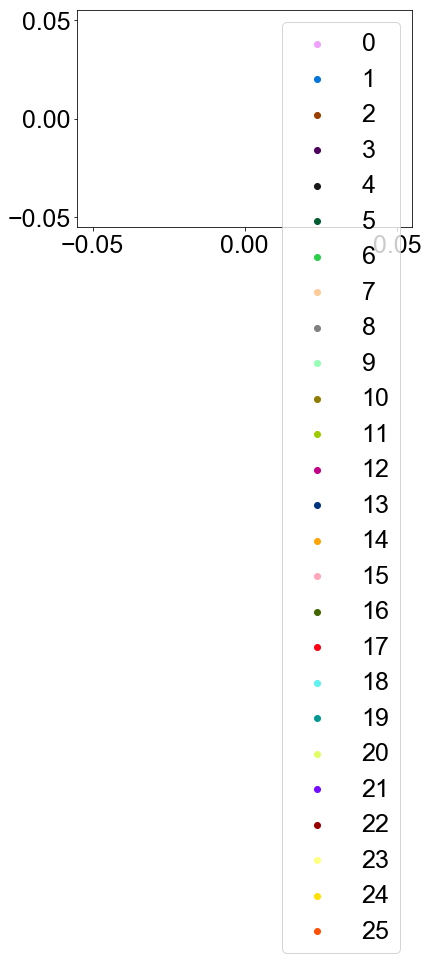

In [136]:
def DiscretePalette(n, palette=None):
    palettes={
                'alphabet':[
                  "#F0A0FF", "#0075DC", "#993F00", "#4C005C", "#191919", "#005C31",
                  "#2BCE48", "#FFCC99", "#808080", "#94FFB5", "#8F7C00", "#9DCC00",
                  "#C20088", "#003380", "#FFA405", "#FFA8BB", "#426600", "#FF0010",
                  "#5EF1F2", "#00998F", "#E0FF66", "#740AFF", "#990000", "#FFFF80",
                  "#FFE100", "#FF5005"
                ],
                'alphabet2':[
                  "#AA0DFE", "#3283FE", "#85660D", "#782AB6", "#565656", "#1C8356",
                  "#16FF32", "#F7E1A0", "#E2E2E2", "#1CBE4F", "#C4451C", "#DEA0FD",
                  "#FE00FA", "#325A9B", "#FEAF16", "#F8A19F", "#90AD1C", "#F6222E",
                  "#1CFFCE", "#2ED9FF", "#B10DA1", "#C075A6", "#FC1CBF", "#B00068",
                  "#FBE426", "#FA0087"
                ],
                'glasbey':[
                  "#0000FF", "#FF0000", "#00FF00", "#000033", "#FF00B6", "#005300",
                  "#FFD300", "#009FFF", "#9A4D42", "#00FFBE", "#783FC1", "#1F9698",
                  "#FFACFD", "#B1CC71", "#F1085C", "#FE8F42", "#DD00FF", "#201A01",
                  "#720055", "#766C95", "#02AD24", "#C8FF00", "#886C00", "#FFB79F",
                  "#858567", "#A10300", "#14F9FF", "#00479E", "#DC5E93", "#93D4FF",
                  "#004CFF", "#F2F318"
                ],
                'polychrome':[
                  "#5A5156", "#E4E1E3", "#F6222E", "#FE00FA", "#16FF32", "#3283FE",
                  "#FEAF16", "#B00068", "#1CFFCE", "#90AD1C", "#2ED9FF", "#DEA0FD",
                  "#AA0DFE", "#F8A19F", "#325A9B", "#C4451C", "#1C8356", "#85660D",
                  "#B10DA1", "#FBE426", "#1CBE4F", "#FA0087", "#FC1CBF", "#F7E1A0",
                  "#C075A6", "#782AB6", "#AAF400", "#BDCDFF", "#822E1C", "#B5EFB5",
                  "#7ED7D1", "#1C7F93", "#D85FF7", "#683B79", "#66B0FF", "#3B00FB"
                ],
                'stepped':[
                  "#990F26", "#B33E52", "#CC7A88", "#E6B8BF", "#99600F", "#B3823E",
                  "#CCAA7A", "#E6D2B8", "#54990F", "#78B33E", "#A3CC7A", "#CFE6B8",
                  "#0F8299", "#3E9FB3", "#7ABECC", "#B8DEE6", "#3D0F99", "#653EB3",
                  "#967ACC", "#C7B8E6", "#333333", "#666666", "#999999", "#CCCCCC"
                ]
            }
    if palette is None:
        if n<=26:
            palette="alphabet"
        elif n<=32:
            palette="glasbey"
        else:
            palette="polychrome"
    
    palette_array= palettes[palette]
    #print(len(palette_array))
    assert n<=len(palette_array), "Not enough colours in specified palette"

    return np.array(palette_array)[np.arange(n)]


color_list=DiscretePalette(26)
for idx,color in enumerate(color_list):
    plt.scatter([],[],c=color,label=idx)
plt.legend()
#plt.sca
#pd.DataFrame({'color':color_list,
#             'x':np.arange(len(color_list))
#             }).plot.scatter(x='x',y='x',c='color')

In [137]:
from PIL import ImageColor



def category_to_color_category(category,mode='color'):
    color=(0,0,0,256)
    if 'Hemato' in category:##
        #color=(180,5,5,256)
        color=ImageColor.getcolor(color_list[17], "RGBA")
    elif 'Anthropomet' in category:##
        #color=(5,5,180,256)
        color=ImageColor.getcolor(color_list[1], "RGBA")
    elif 'Protein' in category:##
        #color=(5,180,5,256)        
        color=ImageColor.getcolor(color_list[2], "RGBA")
    elif 'Metabolic' in category:##
        #color=(160,120,20,256)
        color=ImageColor.getcolor(color_list[3], "RGBA")
    elif 'Liver' in category:
        #color=(120,20,160,256)
        color=ImageColor.getcolor(color_list[14], "RGBA")
    elif 'Kidney' in category:##
        #color=(20,120,160,256)
        color=ImageColor.getcolor(color_list[5], "RGBA")
    elif 'Blood-pressure' in category:
        #color=(256,50,5,256)
        color=ImageColor.getcolor(color_list[6], "RGBA")
    elif 'Cardio' in category:
        color=ImageColor.getcolor(color_list[12], "RGBA")
        pass
    elif 'Thyr' in category:
        color=ImageColor.getcolor(color_list[10], "RGBA")
    elif 'Immune' in category:
        color=ImageColor.getcolor(color_list[21], "RGBA")
    elif 'Nervou' in category:
        color=ImageColor.getcolor(color_list[22], "RGBA")
    elif 'Orth' in category:
        color=ImageColor.getcolor(color_list[25], "RGBA")
        
    elif 'Canc' in category:
        color=ImageColor.getcolor(color_list[16], "RGBA")
    elif 'Eye' in category:
        color=ImageColor.getcolor(color_list[11], "RGBA")
        
    if mode=='color':
        return np.array(color)/256
    else:
        return category.replace(' disease','').replace(' QTL','')
    

In [138]:
def gene_to_color_category(gene_name,mode='color'):
    if gene_name in ['HLA-A','HLA-B','HLA-C']:
        #color='#fa3c14'
        #250, 58, 20
        color=1/256*np.array((250,58,20,256))
        category='Classical HLA gene (class I)'
    elif gene_name in ['HLA-DPA1', 'HLA-DPB1','HLA-DQA1', 'HLA-DQB1','HLA-DRB1','HLA-DRA']:
        #color='#2850c8'
        color=1/256*np.array((40, 80, 200,256))
        category='Classical HLA gene (class II)'
    elif gene_name in ['HLA-F', 'HLA-G', 'HLA-E', 'HLA-DRB5', 'HLA-DQA2', 'HLA-DQB2', 'HLA-DOB', 'HLA-DMB', 'HLA-DMA', 'HLA-DOA', 'MICA','MICB','TAP2','TAP1']:
        #color='#28c828'
        color=1/256*np.array((40, 200, 40,256))
        category='Nonclassical HLA gene'
    else:
        #color='#fafac8'
        color=1/256*np.array((250, 250, 200,256))
        color[:3]=color[:3]*0.1
        color=1/256*np.array((0, 0, 0,256))
        category='Other genes'
    if mode=='color':
        return color
    elif mode=='category':
        return category

In [139]:
dftemp=pd.DataFrame(index=HLA_result_heatmap_significant.columns)
dftemp['color']=HLA_result_heatmap_significant.columns.map(lambda x: gene_to_color_category(x,'color'))
dftemp['category']=HLA_result_heatmap_significant.columns.map(lambda x: gene_to_color_category(x,'category'))
dftemp['x']=np.arange(len(dftemp))

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

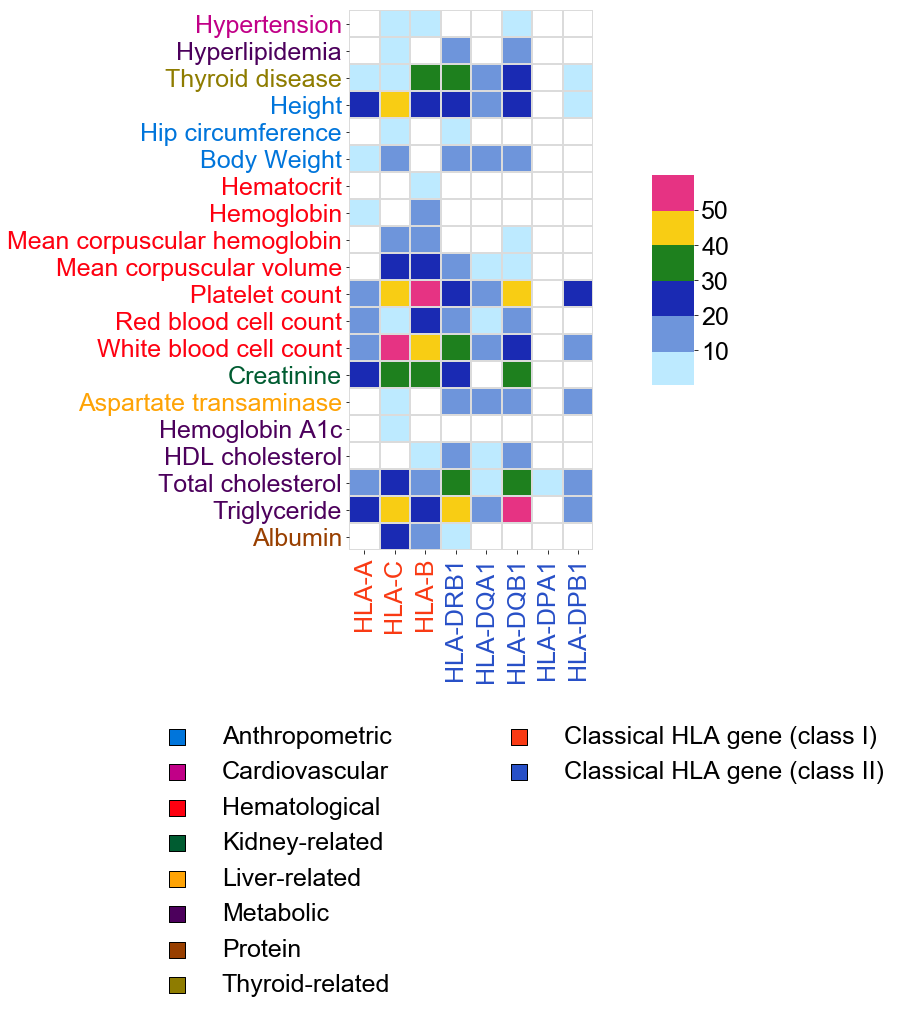

In [140]:
plt.rcParams['font.family']='Arial'
plt.rcParams["font.size"] = 25


import matplotlib.gridspec as gridspec
import seaborn as sns


fig = plt.figure(figsize=(5+1+2, 10+3+4)) 


gs=fig.add_gridspec(10+3+4,5+1+3)

fig_heatmap=fig.add_subplot(gs[0:10,0:5])
fig_heatmap_cmap=fig.add_subplot(gs[0+3:10-3, 5+1:5+1+1])

sns.heatmap(HLA_result_heatmap_significant,
            ax=fig_heatmap,
            cmap=custom_cmap,
            vmin=0,
            vmax=60,
            linewidths=1,
            linecolor=np.array([220,220,220,256])/256,
            cbar_ax=fig_heatmap_cmap,
            cbar_kws={'fraction':0.1, "ticks":[10, 20, 30, 40, 50]},
            cbar=True,
            alpha=1,edgecolor='black')

fig_heatmap.set_ylabel('')
fig_heatmap.set_xlabel('')

for ticklabel in fig_heatmap.yaxis.get_ticklabels():
    phenotype_name=ticklabel.get_text()
    phenotype_category=phenotype_info.loc[phenotype_name]['phenotype_category']
    ticklabel.set_color(category_to_color_category(phenotype_category,'color'))
fig_heatmap.set_yticklabels([phenotype_info.loc[item.get_text()]['phenotype_name_publication'] for item in fig_heatmap.get_yticklabels()])


for ticklabel in fig_heatmap.xaxis.get_ticklabels():
    gene_name=ticklabel.get_text()
    ticklabel.set_color(gene_to_color_category(gene_name,'color'))
    

fig_legend=fig.add_subplot(gs[10+3:10+3+4, 0:5])


category_color_df=pd.DataFrame([phenotype_info.loc[HLA_result_heatmap_significant.index]['phenotype_category'].map(lambda x: category_to_color_category(x,'category')).values,
                                phenotype_info.loc[HLA_result_heatmap_significant.index]['phenotype_category'].map(lambda x: category_to_color_category(x,'color')).values,
                ],index=['category','color']).T
category_color_df=category_color_df[~category_color_df.duplicated('category')]
category_color_df=category_color_df.sort_values('category')
category_color_df=pd.concat([category_color_df[~category_color_df['category'].str.contains('Other')],
               category_color_df[category_color_df['category'].str.contains('Other')]])
legend1=fig_legend.legend(
                        [plt.scatter([],[], marker = 's', s=250, c=row['color'], edgecolor='black', label = row['category']) for (idx,row) in category_color_df.iterrows()],
                        [row['category'] for (idx,row) in category_color_df.iterrows()],
                        loc='upper left',bbox_to_anchor=(-0.9, 1.1),frameon=False
    
)

#print(category_color_df.head())
fig_legend.axis("off")
category_color_df=pd.DataFrame([HLA_result_heatmap_significant.columns.map(lambda x: gene_to_color_category(x,'category')),
                            HLA_result_heatmap_significant.columns.map(lambda x: gene_to_color_category(x,'color')),
                ],index=['category','color']).T
category_color_df=category_color_df[~category_color_df.duplicated('category')]
category_color_df=category_color_df.sort_values('category')
category_color_df=pd.concat([category_color_df[~category_color_df['category'].str.contains('Other')],
               category_color_df[category_color_df['category'].str.contains('Other')]])
legend2=fig_legend.legend(
                    [plt.scatter([],[], marker = 's', s=250, c=row['color'], edgecolor='black', label = row['category']) for (idx,row) in category_color_df.iterrows()],
                    [row['category'] for (idx,row) in category_color_df.iterrows()],
                   loc='upper left',bbox_to_anchor=(0.5, 1.1),frameon=False
    
)


#print(category_color_df.head())
plt.gca().add_artist(legend1)

fig_legend.axis("off")
#fig_legend.legend()

plt.style.use('default')

plt.savefig(data_out_pub_path+'HLA_omnibus.png', bbox_inches='tight')
  

# Matrix

In [190]:
phewas_data=result_all_pub[ (result_all_pub['P_significant']==1) ][['phenotype_name','gene','P']]
phewas_data.shape


(69, 3)

In [191]:
phewas_data[phewas_data['phenotype_name']=='hematocrit']

,phenotype_name,gene,P
Unnamed: 0.1,,,
314361,hematocrit,AGER,9.197860e-13
291010,hematocrit,HLA-B,1.049540e-09
267912,hematocrit,HLA-F,9.911020e-09


In [192]:
#phewas_data.loc[phewas_data.index.max()+1]=['hematocrit','RNF5',9.197860e-13]
#phewas_data.loc[phewas_data.index.max()+1]=['hematocrit','AGER',9.197860e-13]
#phewas_data=phewas_data[~((phewas_data['phenotype_name']=='hematocrit') &(phewas_data['gene']=='RNF5,AGER'))]
phewas_data.shape

(69, 3)

In [193]:
phewas_data[phewas_data['phenotype_name']=='hematocrit']

,phenotype_name,gene,P
Unnamed: 0.1,,,
314361,hematocrit,AGER,9.197860e-13
291010,hematocrit,HLA-B,1.049540e-09
267912,hematocrit,HLA-F,9.911020e-09


In [194]:
phewas_data[phewas_data.duplicated(['phenotype_name','gene'],keep=False)]

,phenotype_name,gene,P
Unnamed: 0.1,,,
339246,hdl_cholesterol,BTNL2,1.434950e-14
376310,hdl_cholesterol,BTNL2,1.466540e-10
583434,platelet,BAK1,1.579220e-69
648220,platelet,BAK1,2.417650e-35
454437,thyroid_disease,HLA-DQA1,9.949160e-22
1316160,thyroid_disease,HLA-DQA1,5.128710e-11


In [195]:
phewas_data=phewas_data[~phewas_data.duplicated(['phenotype_name','gene'])]
phewas_data.shape

(66, 3)

In [196]:
phewas_data_2d=phewas_data.pivot(index='phenotype_name',columns='gene',values='P')

In [197]:
phewas_data_2d.loc['hdl_cholesterol']

gene
AGER                 NaN
ATF6B                NaN
BAG6                 NaN
BAK1                 NaN
BTNL2       1.434950e-14
C2                   NaN
C6orf1               NaN
C6orf10              NaN
C6orf100             NaN
HLA-A                NaN
HLA-B                NaN
HLA-C                NaN
HLA-DPB1             NaN
HLA-DQA1             NaN
HLA-DQB1             NaN
HLA-DRB1             NaN
HLA-E                NaN
HLA-F                NaN
HMGA1                NaN
MICA                 NaN
MICB                 NaN
MUC22                NaN
NOTCH4               NaN
OR2J2                NaN
POU5F1               NaN
TAF11                NaN
TCF19                NaN
TRIM27               NaN
UBD                  NaN
UHRF1BP1    6.678210e-10
Name: hdl_cholesterol, dtype: float64

In [198]:
phewas_data_2d=phewas_data_2d.applymap(lambda x: -np.log10(x))

In [199]:
phewas_data_2d=phewas_data_2d[gene_bed.set_index('Gene name').loc[phewas_data_2d.columns].sort_values('Gene start (bp)').index]
phewas_data_2d=phewas_data_2d.loc[phenotype_info.loc[phewas_data_2d.index].sort_values(['phenotype_type','phenotype_category']).index]
#phewas_data_2d.index=phenotype_info.loc[phewas_data_2d.index]['phenotype_name_publication']

In [200]:
gene_bed.set_index('Gene name').loc['C2']

Gene stable ID                                                                  ENSG00000166278
Gene stable ID version                                                       ENSG00000166278.10
Transcript stable ID                                                            ENST00000469372
Transcript stable ID version                                                  ENST00000469372.1
Gene start (bp)                                                                        31865562
Gene end (bp)                                                                          31913449
Transcript start (bp)                                                                  31865562
Transcript end (bp)                                                                    31913298
Protein stable ID                                                               ENSP00000418923
Protein stable ID version                                                     ENSP00000418923.1
Gene description                        

In [201]:
phewas_data_2d_count=(phewas_data_2d>0).sum().to_frame().reset_index()
phewas_data_2d_count['color']=phewas_data_2d_count['gene'].map(lambda x: gene_to_color_category(x,'color'))

In [202]:
phewas_data_2d_count

,gene,0,color
0,TRIM27,2,"[0.0, 0.0, 0.0, 1.0]"
1,C6orf100,1,"[0.0, 0.0, 0.0, 1.0]"
2,OR2J2,1,"[0.0, 0.0, 0.0, 1.0]"
3,UBD,1,"[0.0, 0.0, 0.0, 1.0]"
4,HLA-F,2,"[0.15625, 0.78125, 0.15625, 1.0]"
5,HLA-A,3,"[0.9765625, 0.2265625, 0.078125, 1.0]"
6,HLA-E,1,"[0.15625, 0.78125, 0.15625, 1.0]"
7,MUC22,1,"[0.0, 0.0, 0.0, 1.0]"
8,TCF19,1,"[0.0, 0.0, 0.0, 1.0]"
9,POU5F1,1,"[0.0, 0.0, 0.0, 1.0]"


In [203]:
result_all_pub[(result_all_pub['phenotype_name']==row)&(result_all_pub['gene']==col)]

ValueError: Can only compare identically-labeled Series objects

In [206]:
print(1)

1


In [207]:
phewas_data_2d_noveltycheck=phewas_data_2d.copy()

for row, row_data in phewas_data_2d_noveltycheck.iterrows():
    for col,element in row_data.items():
        #print(row,co)
        if ~np.isnan(element):
            select=result_all_pub[(result_all_pub['phenotype_name']==row)&(result_all_pub['gene']==col)]
            if len(select)!=1:
                print(select[['phenotype_name','gene']])
            if select['novel'].sum()!=0:
                phewas_data_2d_noveltycheck.loc[row,col]=1
            else:
                phewas_data_2d_noveltycheck.loc[row,col]=np.nan

               phenotype_name      gene
Unnamed: 0.1                           
454437        thyroid_disease  HLA-DQA1
1316160       thyroid_disease  HLA-DQA1
             phenotype_name  gene
Unnamed: 0.1                     
583434             platelet  BAK1
648220             platelet  BAK1
               phenotype_name   gene
Unnamed: 0.1                        
339246        hdl_cholesterol  BTNL2
376310        hdl_cholesterol  BTNL2


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

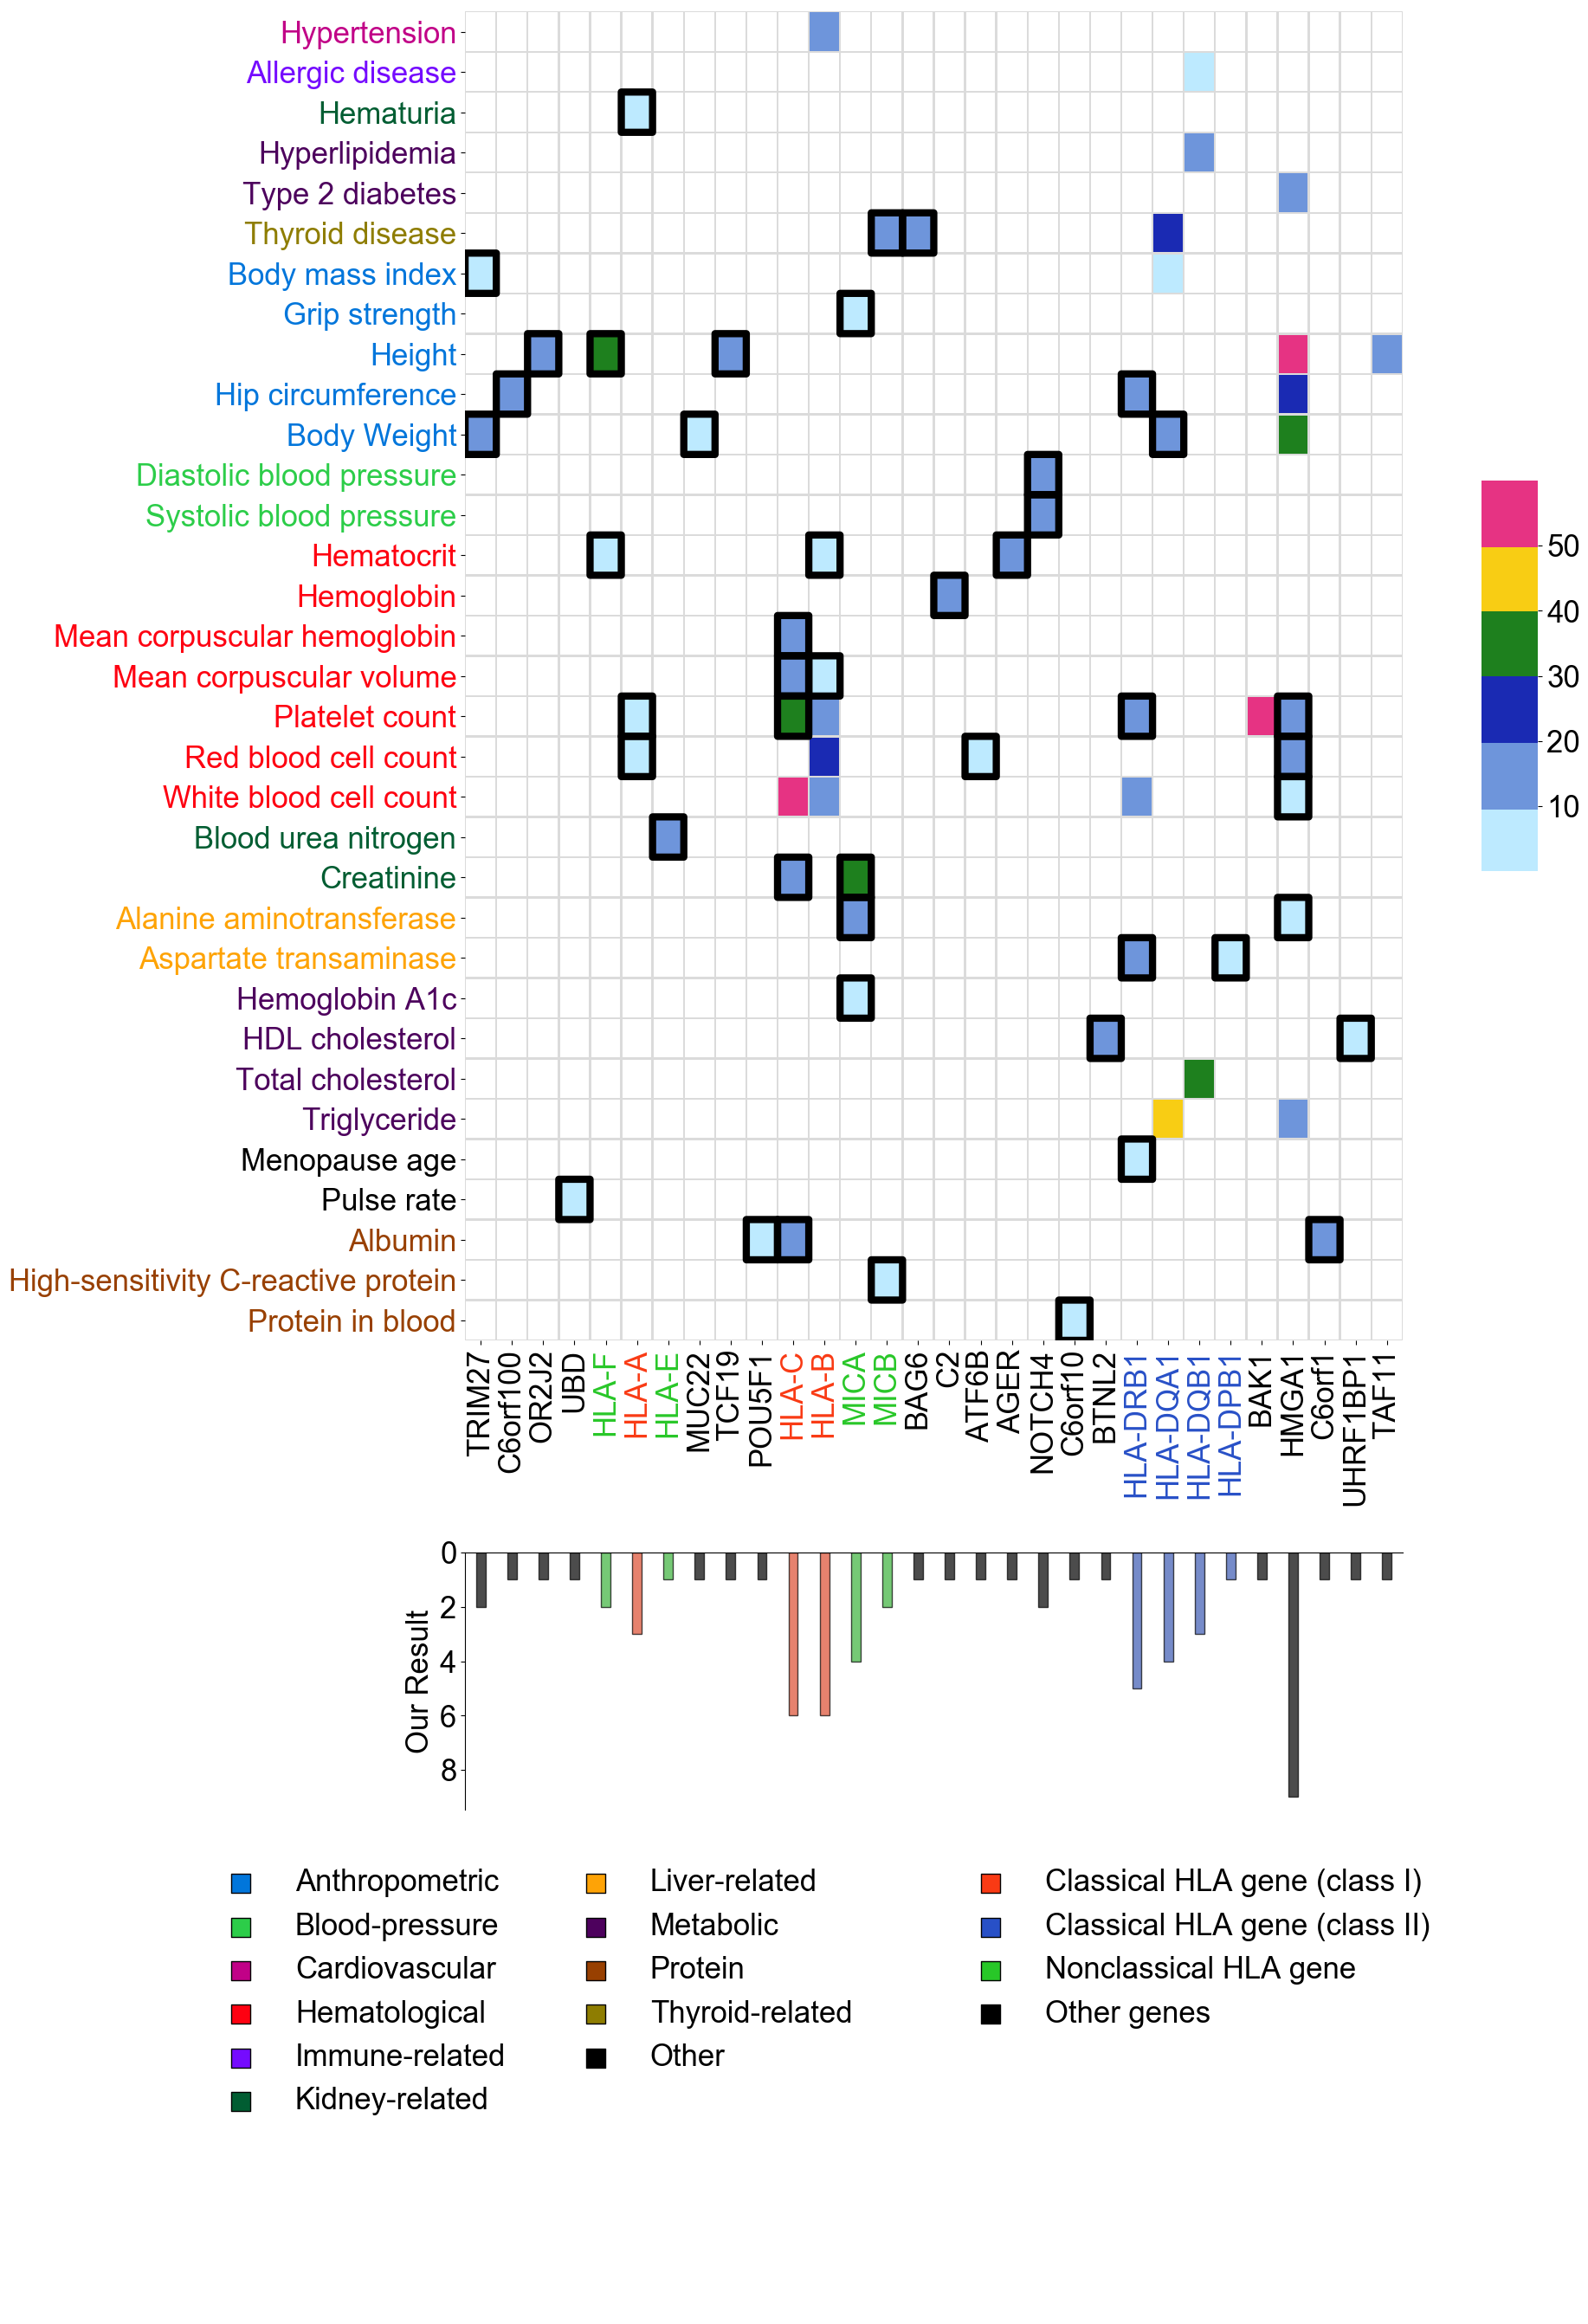

In [208]:
plt.rcParams["figure.figsize"] = (10,15)
plt.rcParams["font.size"] = 25
plt.rcParams['font.family']='Arial'

import matplotlib.gridspec as gridspec
import seaborn as sns

#fig = plt.figure(figsize=(10, 15+3)) 
fig = plt.figure(figsize=(13+1+3, 20+3+4+3+4)) 
gs=fig.add_gridspec(20+3+4+3+4,13+1+3)



#fig_barplot=fig.add_subplot(gs[20:24,0:13])

#gs = gridspec.GridSpec(3, 2, height_ratios=[5, 0.05, 1], width_ratios=[10,1]) 


fig_heatmap=fig.add_subplot(gs[0:20,0:14])
fig_heatmap_cmap=fig.add_subplot(gs[0+7:20-7, 14+1:14+1+1])


sns.heatmap(phewas_data_2d,
            ax=fig_heatmap,
            cmap=custom_cmap,
            vmin=0,
            vmax=60,
            xticklabels=True,
            linewidths=1,
            linecolor=np.array([220,220,220,256])/256,
            cbar_ax=fig_heatmap_cmap,
            cbar_kws={'fraction':0.1, "ticks":[10, 20, 30, 40, 50]},
            cbar=True,
            alpha=1,edgecolor='black')#,legend=None)
##fig.delaxes(fig_heatmap)
from matplotlib.ticker import MultipleLocator, FormatStrFormatter,AutoMinorLocator,MaxNLocator
#from matplotlib import ticker
#tick_locator = ticker.MaxNLocator(10)
#ax.xaxis.set_minor_locator(AutoMinorLocator())
#fig_barplot.minorticks_on()
#ax.xaxis.set_minor_locator(MultipleLocator(0.005))


#fig_heatmap.xaxis.set_major_locator(MaxNLocator(200))
fig_heatmap.set_ylabel('')
fig_heatmap.set_xlabel('')

for ticklabel in fig_heatmap.yaxis.get_ticklabels():
    phenotype_name=ticklabel.get_text()
    phenotype_category=phenotype_info.loc[phenotype_name]['phenotype_category']
    ticklabel.set_color(category_to_color_category(phenotype_category,'color'))
fig_heatmap.set_yticklabels([phenotype_info.loc[item.get_text()]['phenotype_name_publication'] for item in fig_heatmap.get_yticklabels()])

for ticklabel in fig_heatmap.xaxis.get_ticklabels():
    gene_name=ticklabel.get_text()
    ticklabel.set_color(gene_to_color_category(gene_name,'color'))


custom_cmap_white = ListedColormap([[1,1,1,0],
                                    [1,1,1,0],
                                    [1,1,1,0],
                                   ])    
#ax=sns.heatmap(phewas_data_2d_noveltycheck, ax=ax, cmap=custom_cmap_white, vmin=0, vmax=1, linecolor=None, cbar=False, alpha=0.7)#,legend=None)    
fig_heatmap.pcolor(phewas_data_2d_noveltycheck.values, cmap=custom_cmap_white, facecolor=None, edgecolors='black', linewidths=6)#, ax=ax)    
  
    

fig_barplot=fig.add_subplot(gs[20+3:20+3+4,0:14])    
"""
sns.barplot(x='index',y='gene_name',ax=fig_barplot,data=phewas_data_2d_columns_catalog_all_count,
            edgecolor='black',
            palette=list(phewas_data_2d_columns_catalog_all_count['color'].values),alpha=0.3)    
"""
fig_barplot.xaxis.set_visible(False)
fig_barplot.spines['right'].set_visible(False)
fig_barplot.spines['bottom'].set_visible(False)
#fig_barplot.set_ylim(fig_barplot.get_ylim()[::-1])
#fig_barplot.set_ylabel('GWAS Catalog')


fig_barplot2 = fig_barplot#.twinx() 
sns.barplot(x='gene',y=0,data=phewas_data_2d_count,
            edgecolor='black',
            palette=list(phewas_data_2d_count['color'].values),alpha=0.7,ax=fig_barplot2)
fig_barplot2.set_ylim(fig_barplot2.get_ylim()[::-1])
#fig_barplot2.set_ylabel('Our Result (thin)')
fig_barplot2.set_ylabel('Our Result')


for bar in fig_barplot2.patches:
    newwidth=0.3
    
    x = bar.get_x()
    width = bar.get_width()
    centre = x + width/2.
    
    bar.set_x(centre - newwidth/2.)
    bar.set_width(newwidth)

    
#fig_legend=fig.add_subplot(gs[20+3+2:20+3+2+4,0:14])
fig_legend=fig.add_subplot(gs[20+3+4+3:20+3+4+3+4, 0:14])    


category_color_df=pd.DataFrame([phenotype_info.loc[phewas_data_2d.index]['phenotype_category'].map(lambda x: category_to_color_category(x,'category')).values,
                                phenotype_info.loc[phewas_data_2d.index]['phenotype_category'].map(lambda x: category_to_color_category(x,'color')).values,
                ],index=['category','color']).T
category_color_df=category_color_df[~category_color_df.duplicated('category')]
category_color_df=category_color_df.sort_values('category')
category_color_df=pd.concat([category_color_df[~category_color_df['category'].str.contains('Other')],
               category_color_df[category_color_df['category'].str.contains('Other')]])
legend1=fig_legend.legend(
                        [plt.scatter([],[], marker = 's', s=250, c=row['color'], edgecolor='black', label = row['category']) for (idx,row) in category_color_df.iterrows()],
                        [row['category'] for (idx,row) in category_color_df.iterrows()],
                        loc='upper left',bbox_to_anchor=(-0.3, 1.7),frameon=False,
    ncol=2
)

#print(category_color_df.head())
fig_legend.axis("off")
category_color_df=pd.DataFrame([phewas_data_2d.columns.map(lambda x: gene_to_color_category(x,'category')),
                            phewas_data_2d.columns.map(lambda x: gene_to_color_category(x,'color')),
                ],index=['category','color']).T
category_color_df=category_color_df[~category_color_df.duplicated('category')]
category_color_df=category_color_df.sort_values('category')
category_color_df=pd.concat([category_color_df[~category_color_df['category'].str.contains('Other')],
               category_color_df[category_color_df['category'].str.contains('Other')]])
legend2=fig_legend.legend(
                    [plt.scatter([],[], marker = 's', s=250, c=row['color'], edgecolor='black', label = row['category']) for (idx,row) in category_color_df.iterrows()],
                    [row['category'] for (idx,row) in category_color_df.iterrows()],
                   loc='upper left',bbox_to_anchor=(0.5, 1.7),frameon=False   #0.4
)
#print(category_color_df.head())
plt.gca().add_artist(legend1)

plt.style.use('default')
plt.savefig(data_out_pub_path+'phewas.png', bbox_inches='tight')

In [ ]:
print(1)

# univar

In [209]:
result_list=[]
for phenotype_name in binary_continuous_traits:
    #pheno[pheno['pheno']!=-9].to_csv(data_out_gcta_path+phenotype_name+'.phe',sep='\t',index=None,header=None)
    try:
        result=pd.read_csv('data/out_gcta/{}.HEreg'.format(phenotype_name),skiprows=[0,5,6,7,8],sep=r'\s+',index_col=0)
        result=result.astype(float)
        result=result.unstack().to_frame().sort_index(level=1).T
    except:
        print(phenotype_name,'pass')
        continue

    result.columns = result.columns.map(lambda x: '-'.join(x[::-1]))
    result.index=[phenotype_name]#[result_file.split('/')[-1].split('.')[0]]

    pheno=pd.read_csv(data_out_pheno_path+phenotype_name+'.phe',sep='\t',header=None,names=['FID','IID','pheno'])
    phenotype_type='binary' if len(pheno['pheno'][pheno['pheno']!=-9].value_counts())<3 else 'continuous'
        
    result['phenotype_type']=phenotype_type
    #print(result.columns)
    if phenotype_type=='binary':
        with open(data_out_pheno_path+phenotype_name+'.phe'+'.prev','r') as f:
            prev=float(f.read())
        #print('prev',prev)   
        result['prevalence']=prev
    result_list.append(result)  

In [210]:
from scipy.stats import norm
def h2_obs_to_liab(h2_obs, P, K):
    '''
    Converts heritability on the observed scale in an ascertained sample to heritability
    on the liability scale in the population.
    Parameters
    ----------
    h2_obs : float
        Heritability on the observed scale in an ascertained sample.
    P : float in (0,1)
        Prevalence of the phenotype in the sample.
    K : float in (0,1)
        Prevalence of the phenotype in the population.
    Returns
    -------
    h2_liab : float
        Heritability of liability in the population.
    '''
    if np.isnan(P) and np.isnan(K):
        return h2_obs
    if K <= 0 or K >= 1:
        raise ValueError('K must be in the range (0,1)')
    if P <= 0 or P >= 1:
        raise ValueError('P must be in the range (0,1)')

    thresh = norm.isf(K)
    conversion_factor = K ** 2 * \
        (1 - K) ** 2 / (P * (1 - P) * norm.pdf(thresh) ** 2)
    return h2_obs * conversion_factor

In [211]:
result_uni=pd.concat(result_list)

/home/ch6845/tools/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [212]:
result_uni['h2_liab']=result_uni.apply(lambda row: h2_obs_to_liab(row['V(G)/Vp-Estimate'],row['prevalence'],row['prevalence']) if row['phenotype_type']=='binary' else row['V(G)/Vp-Estimate'],axis=1)

In [213]:
#result=pd.read_csv('data/out_gcta/{}.HEreg'.format(phenotype_name),skiprows=[0,5,6,7,8],sep=r'\s+',index_col=0)
#result_concat

In [214]:
result_uni.to_csv('data/gcta_result_uni.tsv',sep='\t')

In [215]:
toplot

NameError: name 'toplot' is not defined

In [218]:
result_concat=result_uni

/home/ch6845/tools/miniconda3/lib/python3.7/site-packages/pandas/plotting/_core.py:185: UserWarning: 'colors' is being deprecated. Please use 'color'instead of 'colors'
  warnings.warn(("'colors' is being deprecated. Please use 'color'"
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with 

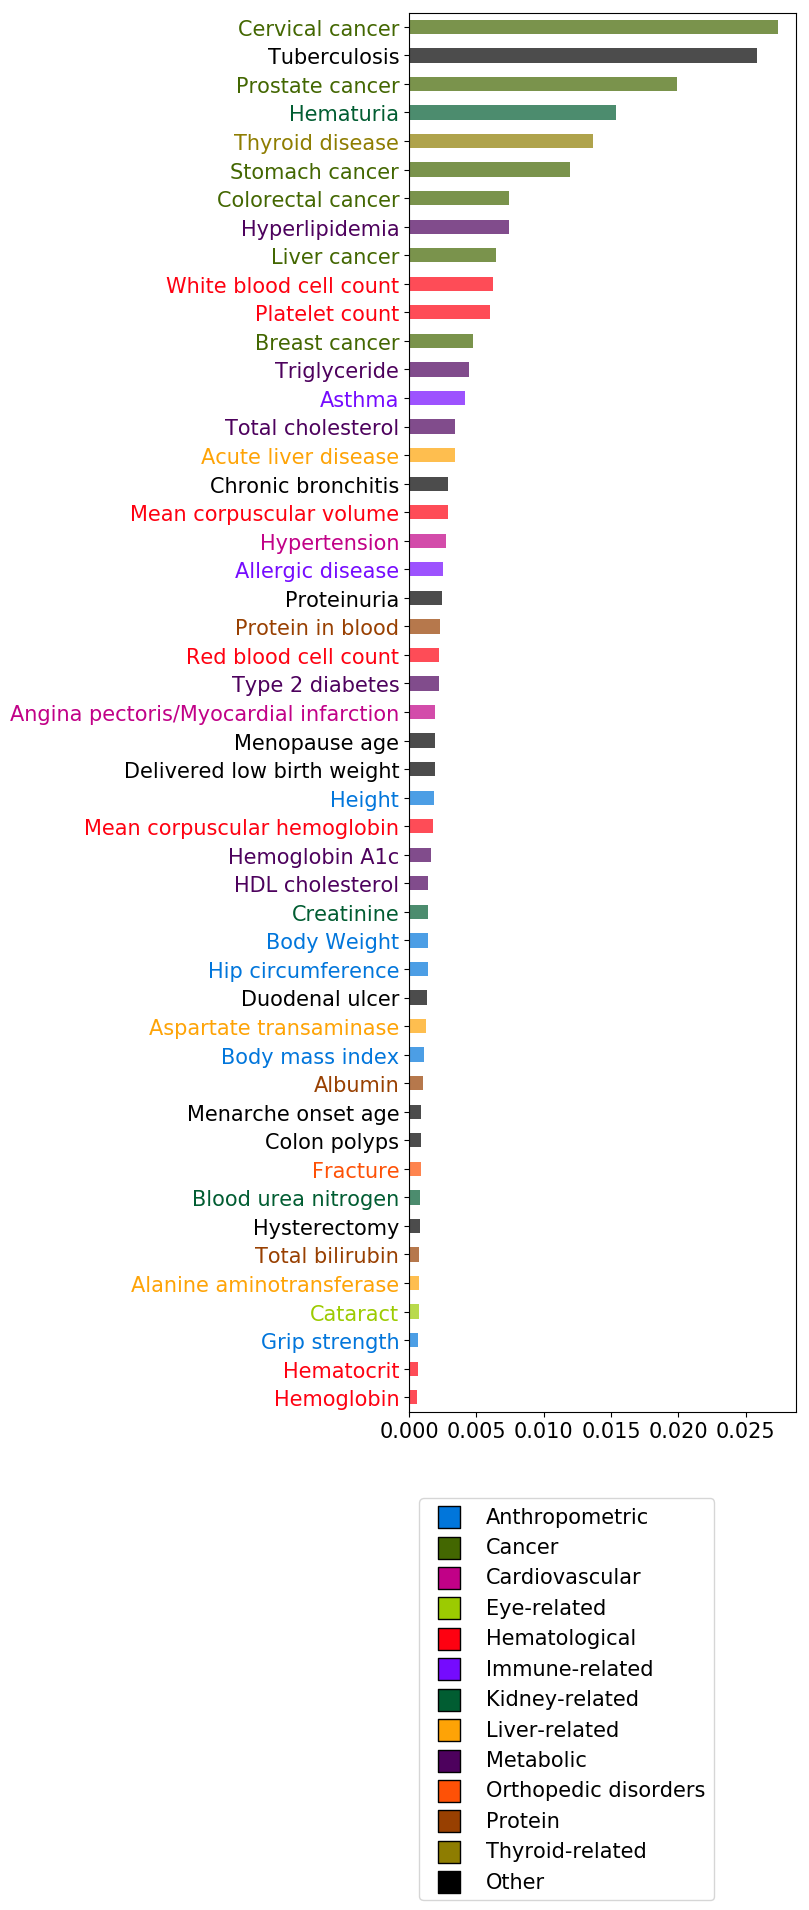

In [219]:
toplot=result_concat[result_concat['h2_liab']>0].copy()
toplot=toplot.sort_values('h2_liab',ascending=True).iloc[int(3*len(toplot)/10):]
toplot['color']=toplot.index.map(lambda x: category_to_color_category(phenotype_info.loc[x]['phenotype_category'],'color'))

#plt.rcParams["figure.figsize"] = (5,30)
plt.rcParams["font.size"] = 15


fig = plt.figure(figsize=(5, 20)) 
gs=fig.add_gridspec(20+2,5)
#ax=fig.add_subplot(1,1,1)

fig_barplot=fig.add_subplot(gs[0:20,0:5])
"""
sns.barplot(
    x='h2_liab',
    y=0,
    data=toplot,
    ax=ax
)
"""
toplot['h2_liab'].plot.barh(linewidth=0.1,
                            colors=list(toplot['color'].values),
                            alpha=0.7,
                            ax=fig_barplot)

for ticklabel in fig_barplot.yaxis.get_ticklabels():
    phenotype_name=ticklabel.get_text()
    phenotype_category=phenotype_info.loc[phenotype_name]['phenotype_category']
    ticklabel.set_color(category_to_color_category(phenotype_category,'color'))

fig_barplot.set_yticklabels([phenotype_info.loc[item.get_text()]['phenotype_name_publication'] for item in fig_barplot.get_yticklabels()])






fig_legend=fig.add_subplot(gs[20:20+2, 0:5])   

category_color_df=pd.DataFrame([phenotype_info.loc[toplot.index]['phenotype_category'].map(lambda x: category_to_color_category(x,'category')).values,
                                phenotype_info.loc[toplot.index]['phenotype_category'].map(lambda x: category_to_color_category(x,'color')).values,
                ],index=['category','color']).T
category_color_df=category_color_df[~category_color_df.duplicated('category')]
category_color_df=category_color_df.sort_values('category')
category_color_df=pd.concat([category_color_df[~category_color_df['category'].str.contains('Other')],
               category_color_df[category_color_df['category'].str.contains('Other')]])

legend1=fig_legend.legend(
                        [plt.scatter([],[], marker = 's', s=250, c=row['color'], edgecolor='black', label = row['category']) for (idx,row) in category_color_df.iterrows()],
                        [row['category'] for (idx,row) in category_color_df.iterrows()],
                        loc='upper left',bbox_to_anchor=(0, 0.5)
)


fig_legend.axis("off")


plt.savefig(data_out_pub_path+'h2_uni.png', bbox_inches='tight')
#plt.savefig('figure_h2.svg', bbox_inches='tight')

# bivar

In [220]:
rG_matrix_upper=np.zeros((len(result_uni),len(result_uni)))
rG_SE_matrix_upper=np.zeros((len(result_uni),len(result_uni)))

In [221]:
for i in range(0,len(result_uni)):
    for j in range(i+1,len(result_uni)):
        phenotype_name1=result_uni.iloc[i].name
        phenotype_name2=result_uni.iloc[j].name


        if os.path.exists(data_out_gcta_path+phenotype_name1+'-'+phenotype_name2+'.HEreg'):
            pass
        elif os.path.exists(data_out_gcta_path+phenotype_name2+'-'+phenotype_name1+'.HEreg'):
            (phenotype_name2,phenotype_name1)=phenotype_name1,phenotype_name2
        elif os.path.exists(data_out_gcta_path+phenotype_name2+'-'+phenotype_name1+'.log'):
            #print(phenotype_name1,phenotype_name2,'missing')
            with open(data_out_gcta_path+phenotype_name2+'-'+phenotype_name1+'.log') as f:
                if 'no phenotype data is found' in f.read():
                    continue
        elif os.path.exists(data_out_gcta_path+phenotype_name1+'-'+phenotype_name2+'.log'):
            #print(phenotype_name1,phenotype_name2,'missing')
            with open(data_out_gcta_path+phenotype_name1+'-'+phenotype_name2+'.log') as f:            
                if 'no phenotype data is found' in f.read():
                    continue            
        else:
            print(phenotype_name1,phenotype_name2)
            continue
            
        #result1=pd.read_csv(data_out_gcta_path+'{}.HEreg'.format(phenotype_name1),skiprows=[0,1,2,3,4,5],sep=r'\s+').set_index('Coefficient')#,skiprows=[0,1],sep=r'\s*')
        #result2=pd.read_csv(data_out_gcta_path+'{}.HEreg'.format(phenotype_name2),skiprows=[0,1,2,3,4,5],sep=r'\s+').set_index('Coefficient')#,skiprows=[0,1],sep=r'\s*')
        #pd.read_csv(data_out_gcta_path+phenotype_name1+'-'+phenotype_name2+'.phe',sep='\t',header=None)
        
        result_bivar=pd.read_csv(data_out_gcta_path+'{}-{}.HEreg'.format(phenotype_name1,phenotype_name2),skiprows=[0,1],sep=r'\s+').set_index('Coefficient')
        rG_matrix_upper[i][j]=result_bivar.loc['rG']['Estimate']
        rG_SE_matrix_upper[i][j]=result_bivar.loc['rG']['SE_OLS']        
        

In [222]:
def make_tri(mat):
    upper1=np.triu(mat,k=1)
    upper2=np.triu(mat.T,k=1) 
    
    ret=upper1+upper2 - np.where((upper1==upper2), upper1, 0)
    ret=np.triu(ret,k=1)
    return ret

In [262]:
rG_matrix=make_tri(rG_matrix_upper)
rG_abs_matrix=np.abs(rG_matrix)
rG_SE_matrix=make_tri(rG_SE_matrix_upper)
rG_Z_abs_matrix=np.abs(rG_matrix/rG_SE_matrix)

/home/ch6845/tools/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


In [263]:
rG_matrix_df=pd.DataFrame(rG_matrix,index=result_uni.index,columns=result_uni.index)
rG_abs_matrix_df=pd.DataFrame(rG_abs_matrix,index=result_uni.index,columns=result_uni.index)
#rG_Z_matrix_df=pd.DataFrame(rG_Z_matrix,index=result_uni.index,columns=result_uni.index)
rG_Z_abs_matrix_df=pd.DataFrame(rG_Z_abs_matrix,index=result_uni.index,columns=result_uni.index)
rG_SE_matrix_df=pd.DataFrame(rG_SE_matrix,index=result_uni.index,columns=result_uni.index)

In [264]:
edges=rG_matrix_df.mask(np.tril(np.ones(rG_matrix_df.shape)).astype(np.bool)).stack()
edges=pd.DataFrame([[edge[0][0],edge[0][1],edge[1]] for edge in edges.iteritems()],columns=['source','target','rG'])

In [265]:
edges2=rG_Z_abs_matrix_df.mask(np.tril(np.ones(rG_Z_abs_matrix_df.shape)).astype(np.bool)).stack()
edges2=pd.DataFrame([[edge[0][0],edge[0][1],edge[1]] for edge in edges2.iteritems()],columns=['source','target','Z_abs'])

In [266]:
edges3=rG_abs_matrix_df.mask(np.tril(np.ones(rG_abs_matrix_df.shape)).astype(np.bool)).stack()
edges3=pd.DataFrame([[edge[0][0],edge[0][1],edge[1]] for edge in edges3.iteritems()],columns=['source','target','rG_abs'])

In [267]:
edges=edges.merge(right=edges2,left_on=['source','target'],right_on=['source','target']).merge(right=edges3,left_on=['source','target'],right_on=['source','target'])

In [293]:
#edges_filtered=edges.sort_values('Z_abs',ascending=False).iloc[:int(len(edges)*0.03)]#edges[edges['value']>2]
edges_filtered=edges.sort_values('Z_abs',ascending=False).iloc[:int(len(edges)*0.035)]#edges[edges['value']>2]

In [294]:
edges_filtered.shape

(80, 5)

In [295]:
#edges_filtered=edges_filtered.sort_values('rG_abs',ascending=True)#.iloc[:int(len(edges)*0.03)]#edges[edges['value']>2]
edges_filtered=edges_filtered[edges_filtered['rG_abs']>0.3]
edges_filtered.shape

(77, 5)

In [296]:
groups=[]
for idx,row in edges_filtered.iterrows():
    try:
        group_index=[(row['source'] in groups[i] or row['target'] in groups[i]) for i in range(len(groups))].index(True)
        groups[group_index].add(row['source'])
        groups[group_index].add(row['target'])
    except:
        groups.append({row['source'],row['target']})

In [297]:
groups=sorted(groups,key=lambda x: len(x),reverse=True)

In [298]:
len(groups)

2

In [299]:
#phenotypes_par_filtered['group_id']=
edges_filtered['group_id']=[np.argmax([False]+[row['source'] in group for group in groups]) for idx,row in edges_filtered.iterrows()]

In [300]:
import networkx as nx

In [301]:
edges_filtered[edges_filtered['group_id']==2]

,source,target,rG,Z_abs,rG_abs,group_id


In [302]:
edges_filtered_filtered=edges_filtered[edges_filtered['group_id']==1]
#edges_filtered_filtered=edges_filtered

G_temp=nx.convert_matrix.from_pandas_edgelist(edges_filtered_filtered,edge_attr=['rG','rG_abs','Z_abs'])

#per_bp_var_temp=per_bp_var.copy()
#per_bp_var_temp.index=per_bp_var_temp.index.map(lambda x:description_to_short(code_to_description(x),'pub',2))
nx.set_node_attributes(G_temp,dict([(node,pd.Series(result_uni['V(G)/Vp-Estimate'].loc[node]).iloc[0]) for node in list(G_temp.nodes)]),'heritability')
#nx.set_node_attributes(G_temp,dict([(node,node) for node in list(G.nodes)]),'label')

In [303]:
#G=nx.relabel_nodes(G_temp,lambda x: description_to_short(code_to_description(x),'pub',2))

G=G_temp.copy()#nx.relabel_nodes(G_temp,lambda x:description_to_short(code_to_description(x),'abbr_pub_ori','correlation'))
#pos = nx.kamada_kawai_layout(G,weight='Z_abs')
pos = nx.spring_layout(G,weight='Z_abs')

In [304]:
plt.rcParams["figure.figsize"] = (30,30)
plt.rcParams["font.size"] = 10
#sns.heatmap(rG_matrix_df, annot=True,cmap=plt.get_cmap('PiYG'),center=0,vmin=-1,vmax=1)

In [305]:
import random

angle_map=lambda x: (np.arctan(x[1]/x[0])+(np.pi if x[0]<0 else 0)+2*np.pi)%(2*np.pi)

def draw_arc(a,b):

    center=(a+b)/2+(1 if random.random()>0.5 else -1)*np.array([(b-a)[1],-(b-a)[0]])*random.uniform(np.sqrt(3)/2,2)

    radius=np.sqrt(np.power(b-center,2).sum())

    a_theta=angle_map(a-center)#arctan_norm((a-center)[1]/(a-center)[0])
    b_theta=angle_map(b-center)
    
    if abs(b_theta-a_theta)>np.pi:
        if a_theta>b_theta:
            a_theta=a_theta-2*np.pi
        else:
            b_theta=b_theta-2*np.pi
            
    try:
        return [center+radius*np.array([np.cos(theta),np.sin(theta)]) for theta in np.arange(min(a_theta,b_theta),max(a_theta,b_theta),abs(b_theta-a_theta)/100)]
    except:
        print('error')
        return [a,b]

#draw_arc(np.array((0,1)),np.array((1,0)))

In [306]:

phenotype_info.loc[node_df.index]['phenotype_category']

total_cholesterol                     Metabolic QTL
triglyceride                          Metabolic QTL
height                           Anthropometric QTL
platelet                          Hematological QTL
hyperlipidemia                    Metabolic disease
creatinine                       Kidney-related QTL
wbc                               Hematological QTL
rbc                               Hematological QTL
thyroid_disease             Thyroid-related disease
mcv                               Hematological QTL
hypertension                 Cardiovascular disease
hip_circumference                Anthropometric QTL
weight                           Anthropometric QTL
mch                               Hematological QTL
bun                              Kidney-related QTL
hdl_cholesterol                       Metabolic QTL
diastolic_blood_pressure         Blood-pressure QTL
bmi                              Anthropometric QTL
hba1c                                 Metabolic QTL
hemoglobin  

In [307]:
#[i[0] for i in edge_df['source_xy'].values]

In [308]:
scatter_hue.max(),scatter_hue.min()

(0.0062347999999999995, 0.000471295)

In [309]:
edge_df[edge_color].abs().max(),edge_df[edge_color].max()

(1.09429, 1.09429)

<Figure size 1500x2000 with 0 Axes>

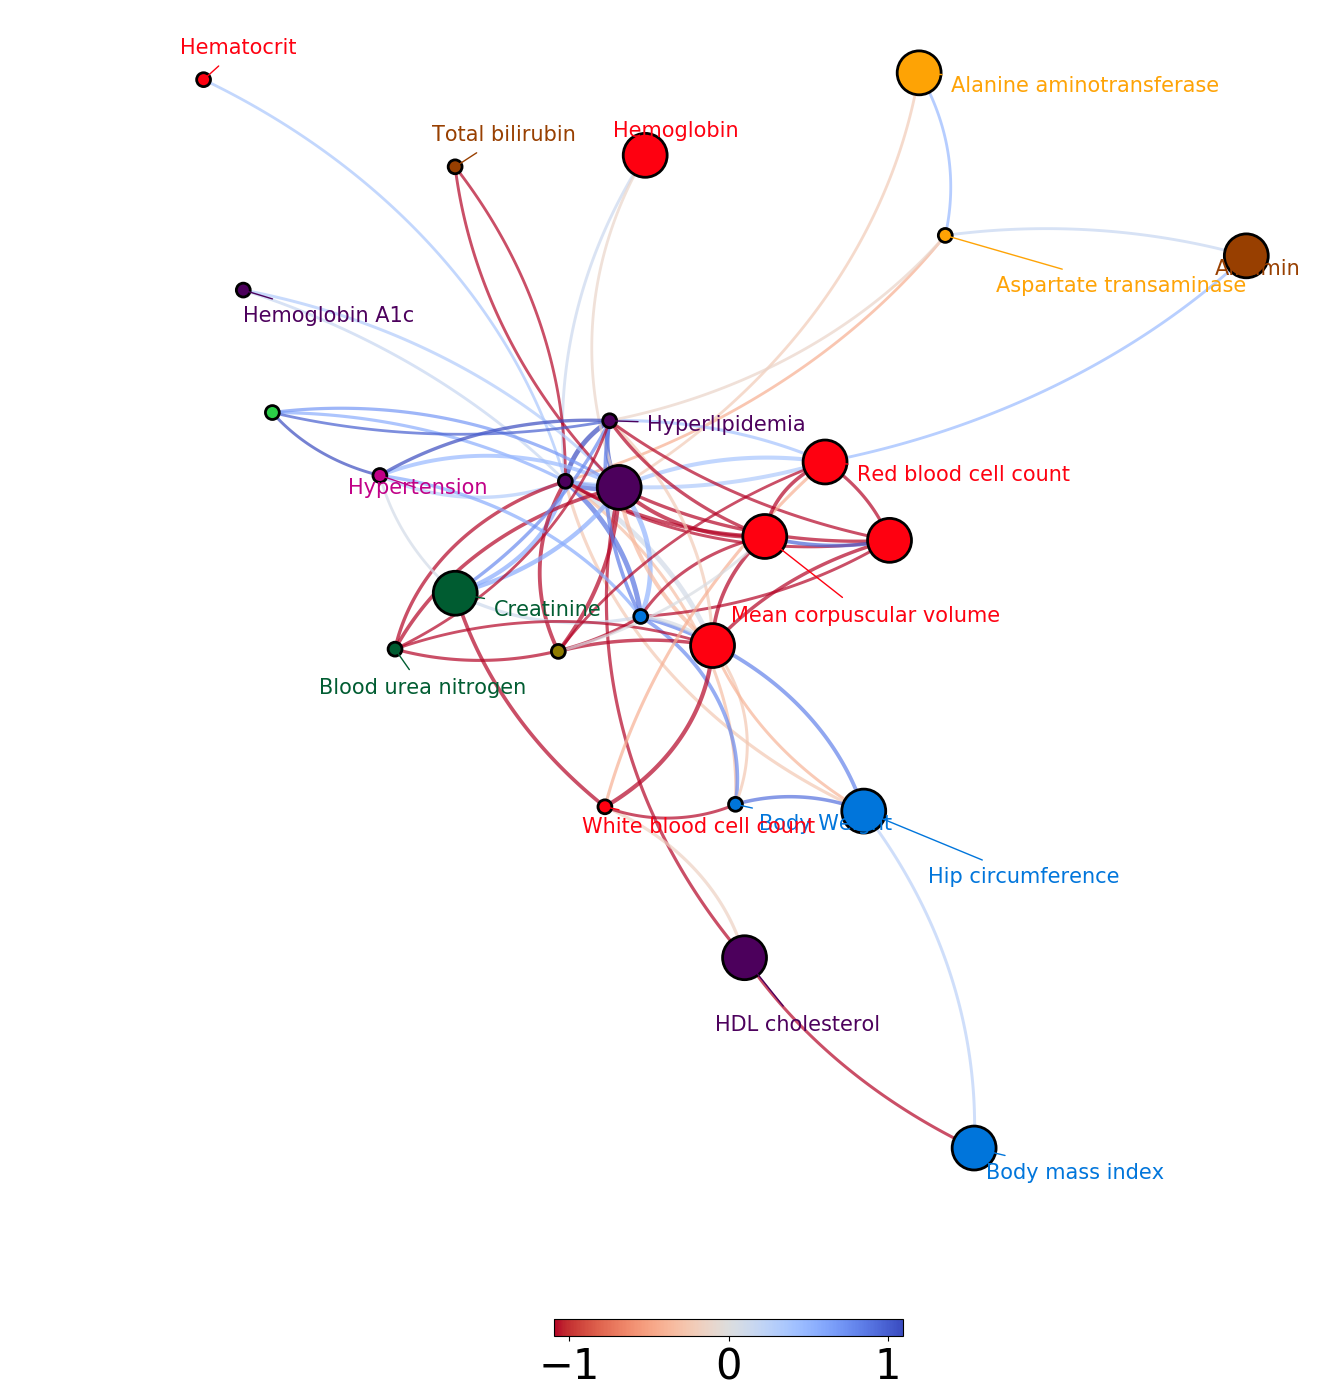

In [310]:
node_color='heritability'
node_size='heritability'

edge_width='Z_abs'
edge_color='rG'

from matplotlib.collections import LineCollection

plt.rcParams["figure.figsize"] = (15,20)
plt.rcParams["font.size"] = 30


#node initialization
node_df=pd.DataFrame([(pos[node]) for node in G.nodes],index=G.nodes,columns=['x','y'])
for node in G.nodes:
    for idx,value in G.nodes[node].items():
        node_df.loc[node,idx]=value

#edge initialization
edge_df=pd.DataFrame([(pos[edge[0]],pos[edge[1]]) for edge in G.edges],index=G.edges,columns=['source_xy','target_xy'])
for edge in G.edges:
    for idx,value in G.edges[edge].items():
        edge_df.loc[edge,idx]=value

############## Drawing ##############
        
# Draw colorbar
"""
scatter_x=node_df['x']
scatter_y=node_df['y']
scatter_hue=node_df[node_color]
points=plt.scatter(x=scatter_x,y=scatter_y,c=scatter_hue,cmap=plt.cm.PiYG)
        
plt.clf()
"""   

#,[
scatter_x=[i[0] for i in edge_df['source_xy'].values]
scatter_y=[i[1] for i in edge_df['source_xy'].values]
scatter_hue=edge_df[edge_color].copy()
scatter_hue.iloc[[0,1]]=[-scatter_hue.abs().max(),scatter_hue.abs().max()]
points=plt.scatter(x=scatter_x,y=scatter_y,c=scatter_hue,cmap=plt.cm.coolwarm.reversed())
        
plt.clf()
  

fig, ax = plt.subplots()

plt.colorbar(points,orientation="horizontal",pad=0.07,shrink=0.3)   

# Draw edges


#line_collection_xy=[[row['source_xy'],(row['source_xy']+row['target_xy'])/2+(0.1,0.1),row['target_xy']] for idx,row in edge_df.iterrows()]
line_collection_xy=[draw_arc(row['source_xy'],row['target_xy']) for idx,row in edge_df.iterrows()]

line_collection_linewidths=np.array([row[edge_width] for idx,row in edge_df.iterrows()])
line_collection_linewidths=(line_collection_linewidths-line_collection_linewidths.min())/(line_collection_linewidths.max()-line_collection_linewidths.min())
line_collection_linewidths=2+3*line_collection_linewidths

line_collection_colors=np.array([plt.cm.coolwarm.reversed()(row[edge_color],alpha=0.7) for idx,row in edge_df.iterrows()])

line_collection=LineCollection(line_collection_xy,zorder=-5,colors=line_collection_colors,linewidths=line_collection_linewidths)
l_c=ax.add_collection(line_collection)

# Draw nodes

scatter_x=node_df['x']
scatter_y=node_df['y']
scatter_hue=node_df[node_color]
#scatter_hue=np.array([plt.cm.rainbow(row[node_color],alpha=0.7) for idx,row in node_df.iterrows()])
#
scatter_size=np.exp(node_df[node_size])
plt.scatter(x=scatter_x,
            y=scatter_y,
            c=list(phenotype_info.loc[node_df.index]['phenotype_category'].map(lambda x: category_to_color_category(x,'color')).values),
            alpha=1,
            s=scatter_size,
            edgecolor='black',
            linewidth=2,
            sizes=(100,1000))#,color='white')#,edgecolor='black')


############## Annotation ##############


r_sample=np.arange(0.05,0.15,0.01)
theta_sample=2*np.pi*np.arange(0,1,0.05)
theta_sample=theta_sample[theta_sample%np.pi>np.pi/5]

np.random.shuffle(theta_sample)
move_sample=[(r*np.cos(theta),r*np.sin(theta)) for theta in theta_sample for r in r_sample]
#print(move_sample)
#print(move_sample)
text_plotted=pd.DataFrame([])
for idx,row in node_df.sort_values('y',ascending=False).iterrows():
    #description_short=idx
    
    s=phenotype_info.loc[idx]['phenotype_name_publication']
    color=category_to_color_category(phenotype_info.loc[idx]['phenotype_category'],'color')
    xy=np.array([row['x'], row['y']])
    np.random.shuffle(theta_sample)
    move_sample=[(r*np.cos(theta),r*np.sin(theta)) for theta in theta_sample for r in r_sample]
    
    for move in move_sample:
        xytext=xy+move
        if text_plotted.shape[0]==0 or (((node_df['x']-xytext[0])**2+(node_df['y']-xytext[1])**2)<1).sum()==0 or (((text_plotted['x']-xytext[0])**2+0.5*(text_plotted['y']-xytext[1])**2)<0.05).sum()==0:
            plt.annotate(s,
                         xy=xy,
                         color=color,
                         xytext=xytext,
                         arrowprops=dict(arrowstyle="-",connectionstyle="arc3,rad=0",ls=None,color=color),
                         bbox= dict(boxstyle="round,pad=0.3", fc=(1,1,1,0), ec="None", lw=0.3),
                         size=15)
            text_plotted=text_plotted.append(pd.DataFrame([{'x':xytext[0],'y':xytext[1]}]))
            break

sns.despine(top=True,right=True,left=True,bottom=True)
plt.axis('off')

#plt.show()
plt.savefig(data_out_pub_path+'h2_bivar.svg', bbox_inches='tight')



In [311]:
import matplotlib as mpl

In [314]:
#G=nx.relabel_nodes(G_temp,lambda x: description_to_short(code_to_description(x),'pub',2))

G=G_temp.copy()#nx.relabel_nodes(G_temp,lambda x:description_to_short(code_to_description(x),'abbr_pub_ori','correlation'))
#pos = nx.kamada_kawai_layout(G,weight='Z_abs')
pos = nx.spring_layout(G,weight='Z_abs')

/home/ch6845/tools/miniconda3/lib/python3.7/site-packages/pandas/plotting/_core.py:185: UserWarning: 'colors' is being deprecated. Please use 'color'instead of 'colors'
  warnings.warn(("'colors' is being deprecated. Please use 'color'"
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with 

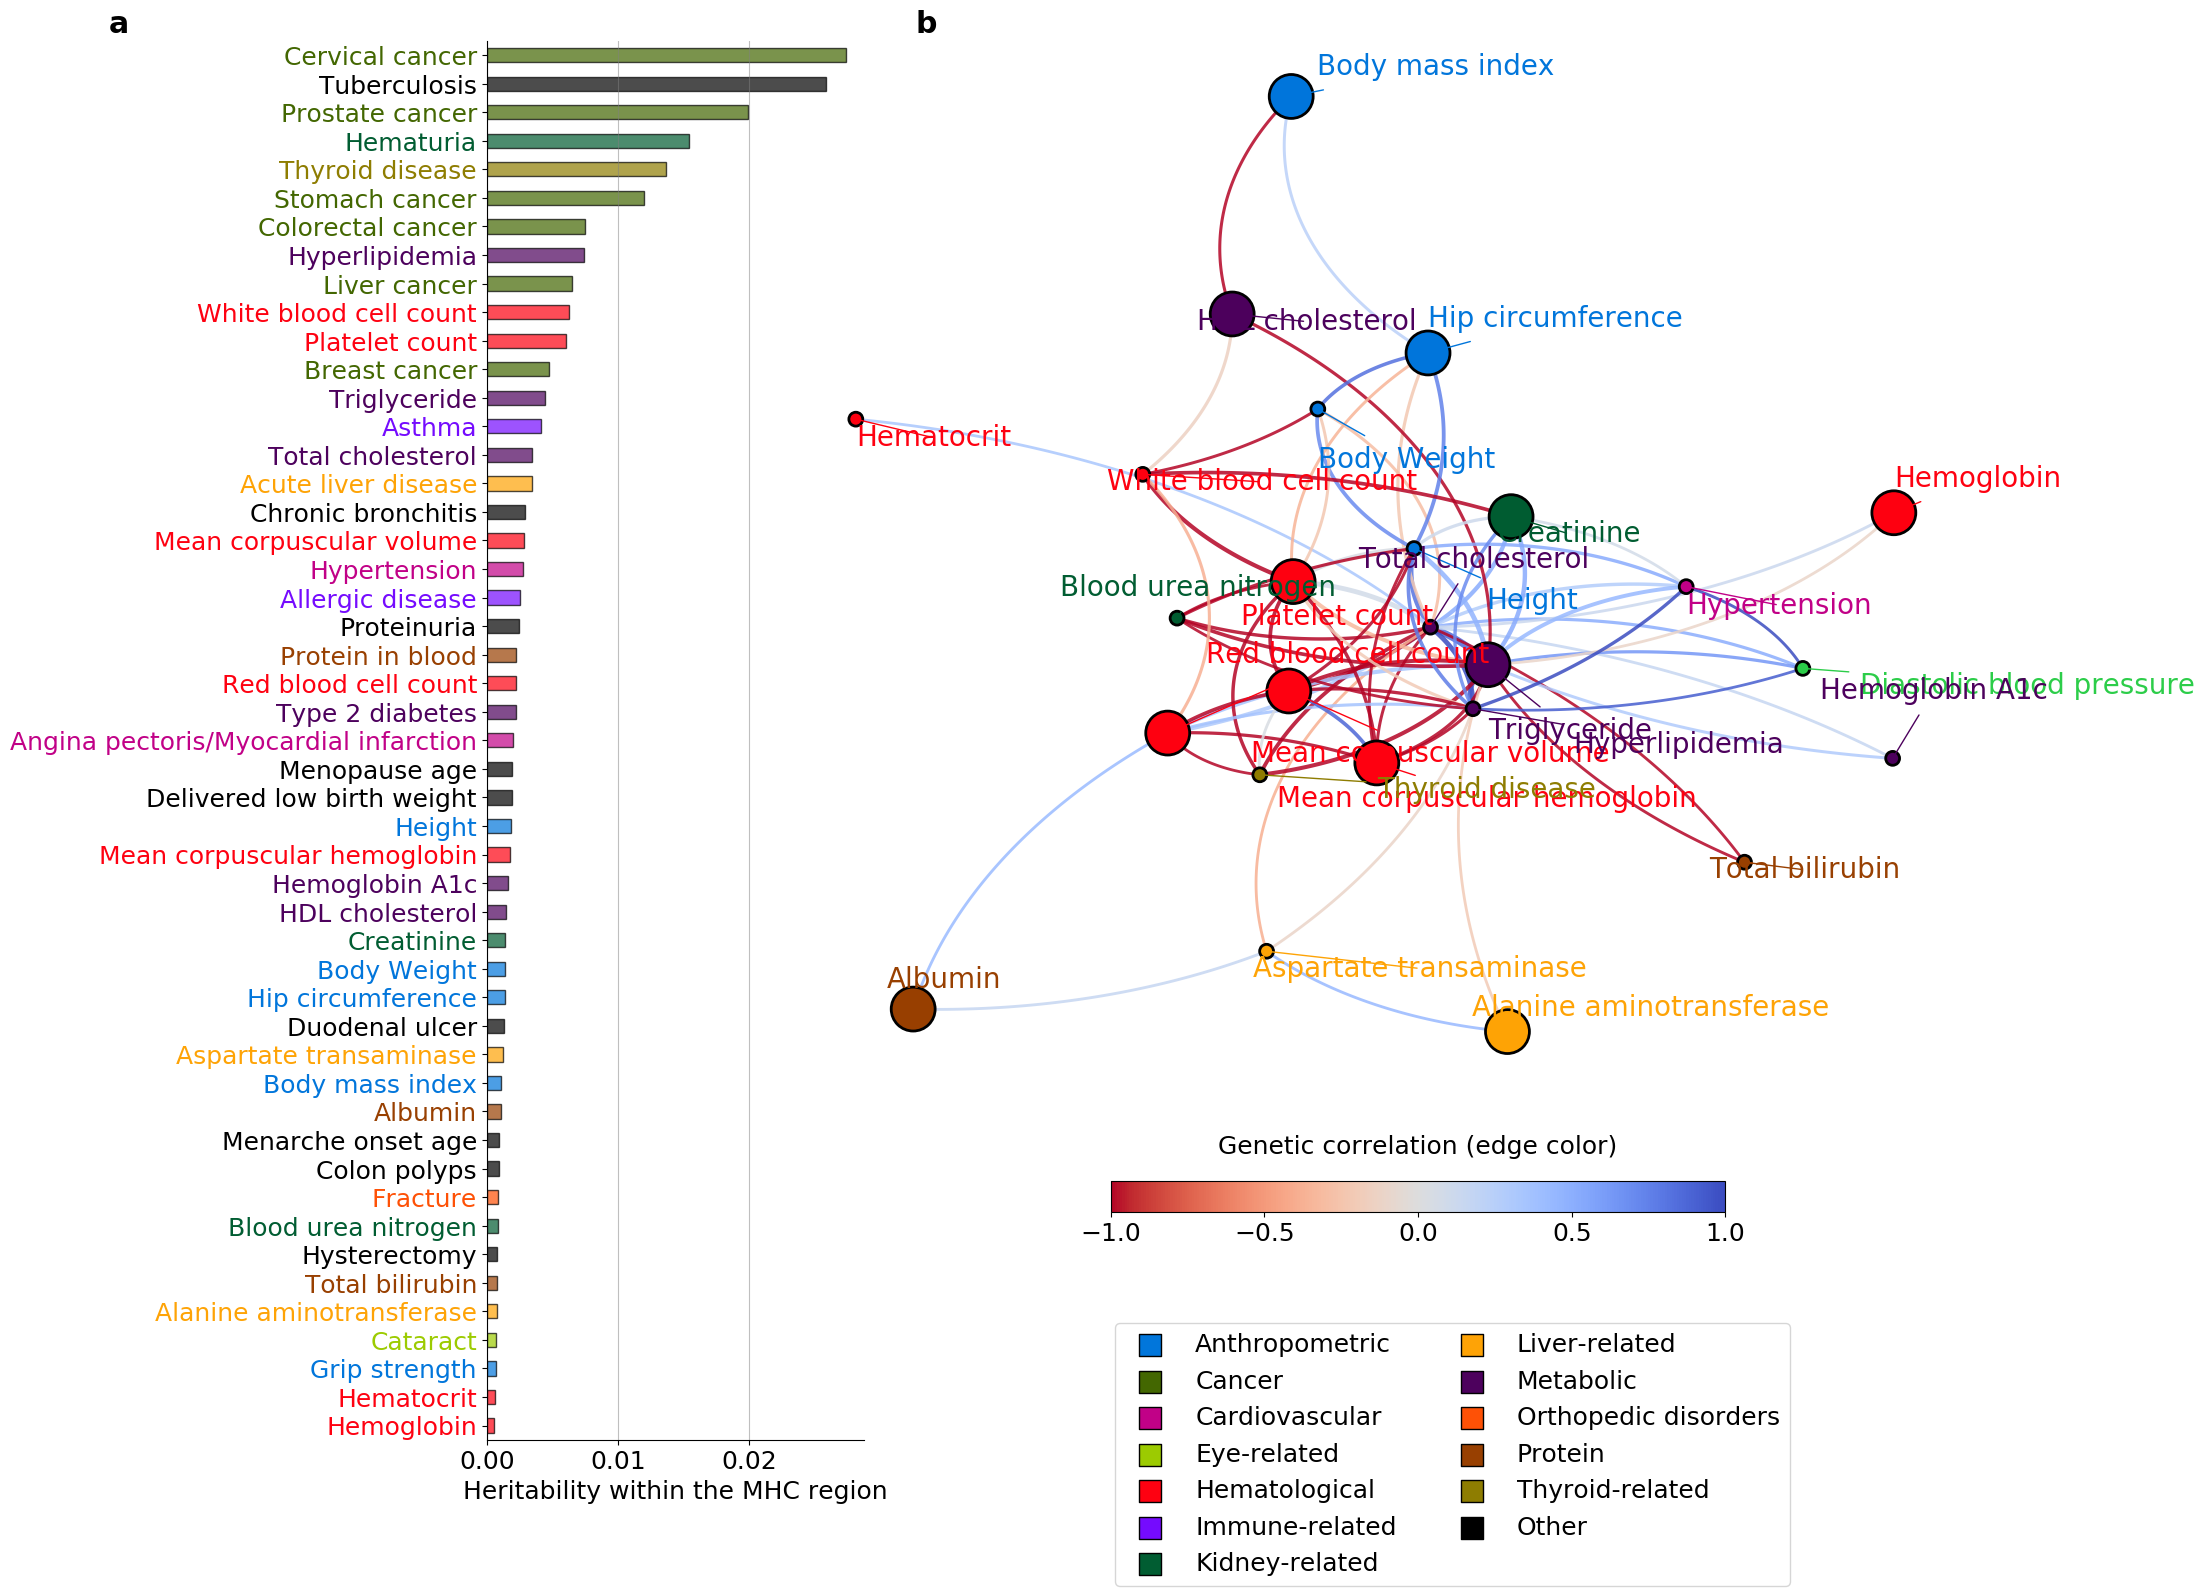

In [315]:
fig = plt.figure(figsize=(5+15, 20)) 
gs=fig.add_gridspec(20+2,5+15)


toplot=result_concat[result_concat['h2_liab']>0].copy()
toplot=toplot.sort_values('h2_liab',ascending=True).iloc[int(3*len(toplot)/10):]
toplot['color']=toplot.index.map(lambda x: category_to_color_category(phenotype_info.loc[x]['phenotype_category'],'color'))

#plt.rcParams["figure.figsize"] = (5,30)
plt.rcParams["font.size"] = 18



#ax=fig.add_subplot(1,1,1)

fig_barplot=fig.add_subplot(gs[0:20,0:5])
"""
sns.barplot(
    x='h2_liab',
    y=0,
    data=toplot,
    ax=ax
)
"""
toplot['h2_liab'].plot.barh(linewidth=1,
                            colors=list(toplot['color'].values),
                            alpha=0.7,
                            edgecolor='black',
                            ax=fig_barplot)

for ticklabel in fig_barplot.yaxis.get_ticklabels():
    phenotype_name=ticklabel.get_text()
    phenotype_category=phenotype_info.loc[phenotype_name]['phenotype_category']
    ticklabel.set_color(category_to_color_category(phenotype_category,'color'))

fig_barplot.set_yticklabels([phenotype_info.loc[item.get_text()]['phenotype_name_publication'] for item in fig_barplot.get_yticklabels()])

#fig_barplot.set_minor_locator(MultipleLocator(0.005))

fig_barplot.set_xlabel('Heritability within the MHC region')

sns.despine(top=True,right=True,left=False,bottom=False,ax=fig_barplot)

#fig_barplot.yaxis.set_minor_locator(MultipleLocator(0.005))

fig_barplot.grid(True, which='major', axis='x', color='gray', alpha=0.5, linestyle='-')
#fig_barplot.grid(True, which='minor', axis='x', color='gray', alpha=0.5, linestyle='-')

#from matplotlib.ticker import MultipleLocator, FormatStrFormatter,AutoMinorLocator

#ax.xaxis.set_minor_locator(AutoMinorLocator())
#fig_barplot.minorticks_on()
#ax.xaxis.set_minor_locator(MultipleLocator(0.005))
#ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))
#ax.tick_params(which='minor', length=4, color='r')

#fig_barplot.grid(True, which='major', axis='x', color='gray', alpha=0.5, linestyle='-')
#fig_barplot.grid(True, which='minor', axis='x', color='gray', alpha=0.5, linestyle='-')


fig_legend=fig.add_subplot(gs[15+3:15+3+2, 12:12+5])   

category_color_df=pd.DataFrame([phenotype_info.loc[toplot.index]['phenotype_category'].map(lambda x: category_to_color_category(x,'category')).values,
                                phenotype_info.loc[toplot.index]['phenotype_category'].map(lambda x: category_to_color_category(x,'color')).values,
                ],index=['category','color']).T
category_color_df=category_color_df[~category_color_df.duplicated('category')]
category_color_df=category_color_df.sort_values('category')
category_color_df=pd.concat([category_color_df[~category_color_df['category'].str.contains('Other')],
               category_color_df[category_color_df['category'].str.contains('Other')]])

legend1=fig_legend.legend(
                        [plt.scatter([],[], marker = 's', s=250, c=row['color'], edgecolor='black', label = row['category']) for (idx,row) in category_color_df.iterrows()],
                        [row['category'] for (idx,row) in category_color_df.iterrows()],
                        loc='upper left',bbox_to_anchor=(0, 0)
)


fig_legend.axis("off")

fig_legend.legend(ncol=2)










fig_network=fig.add_subplot(gs[0:15, 5-1:5+15-1])


node_color='heritability'
node_size='heritability'

edge_width='Z_abs'
edge_color='rG'

from matplotlib.collections import LineCollection


#node initialization
node_df=pd.DataFrame([(pos[node]) for node in G.nodes],index=G.nodes,columns=['x','y'])
for node in G.nodes:
    for idx,value in G.nodes[node].items():
        node_df.loc[node,idx]=value

#edge initialization
edge_df=pd.DataFrame([(pos[edge[0]],pos[edge[1]]) for edge in G.edges],index=G.edges,columns=['source_xy','target_xy'])
for edge in G.edges:
    for idx,value in G.edges[edge].items():
        edge_df.loc[edge,idx]=value

############## Drawing ##############
        
# Draw colorbar
"""
scatter_x=node_df['x']
scatter_y=node_df['y']
scatter_hue=node_df[node_color]
points=plt.scatter(x=scatter_x,y=scatter_y,c=scatter_hue,cmap=plt.cm.PiYG)
        
plt.clf()
"""   

#fig_colorbar=fig.add_subplot(gs[14+1:14+1+2, 12:12+5])   
#,[
#scatter_x=[i[0] for i in edge_df['source_xy'].values]
#scatter_y=[i[1] for i in edge_df['source_xy'].values]
#scatter_hue=edge_df[edge_color].copy()
#scatter_hue.iloc[[0,1]]=[-scatter_hue.abs().max(),scatter_hue.abs().max()]
#points=fig_colorbar.scatter(x=scatter_x,y=scatter_y,c=scatter_hue,cmap=plt.cm.coolwarm.reversed())
        
#plt.clf()
#fig_colorbar.remove()
#fig_colorbar.axis("off")
#fig_colorbar.set_visible(False)


fig_colorbar=fig.add_subplot(gs[14+2:14+2+1, 7:7+10])   
#ax = fig_colorbar.add_axes([0.05, 0.80, 0.9, 0.1])
fig_colorbar.axis('off')

fig_colorbar_ax=mpl.colorbar.make_axes(fig_colorbar, location=None, orientation='horizontal', fraction=0.8, shrink=0.8, aspect=20)

cb = mpl.colorbar.ColorbarBase(fig_colorbar_ax[0], orientation='horizontal', 
                               cmap=plt.cm.coolwarm.reversed(),
                               norm=mpl.colors.Normalize(-1, 1),  # vmax and vmin
                               ticks=[-1, -0.5, 0, 0.5, 1]
                              )

cb.set_label('Genetic correlation (edge color)',labelpad=-80)
#cb.set_label('Genetic correlation (edge color)',y=-100)
#fig_colorbar_ax[0].legend(loc='upper left',bbox_to_anchor=(0, 1))
#fig, ax = plt.subplots()
"""
This solution can be also used to draw the colorbar independenly of the content of ax. Just set fraction = .05.

Code

import matplotlib as mpl
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1)

fraction = 1  # .05

norm = mpl.colors.Normalize(vmin=-3, vmax=99)
cbar = ax.figure.colorbar(
            mpl.cm.ScalarMappable(norm=norm, cmap='Blues'),
            ax=ax, pad=.05, extend='both', fraction=fraction)
"""
#import matplotlib as mpl
#plt.colorbar(plt.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=-1, vmax=1),cmap=plt.cm.coolwarm.reversed()),
#             orientation="horizontal",fraction=1,aspect=30, ax=fig_colorbar)   

# Draw edges


#line_collection_xy=[[row['source_xy'],(row['source_xy']+row['target_xy'])/2+(0.1,0.1),row['target_xy']] for idx,row in edge_df.iterrows()]
line_collection_xy=[draw_arc(row['source_xy'],row['target_xy']) for idx,row in edge_df.iterrows()]

line_collection_linewidths=np.array([row[edge_width] for idx,row in edge_df.iterrows()])
line_collection_linewidths=(line_collection_linewidths-line_collection_linewidths.min())/(line_collection_linewidths.max()-line_collection_linewidths.min())
line_collection_linewidths=2+3*line_collection_linewidths

line_collection_colors=np.array([plt.cm.coolwarm.reversed()(row[edge_color],alpha=0.85) for idx,row in edge_df.iterrows()])

line_collection=LineCollection(line_collection_xy,zorder=-5,colors=line_collection_colors,linewidths=line_collection_linewidths)
l_c=fig_network.add_collection(line_collection)

# Draw nodes

scatter_x=node_df['x']
scatter_y=node_df['y']
scatter_hue=node_df[node_color]
#scatter_hue=np.array([plt.cm.rainbow(row[node_color],alpha=0.7) for idx,row in node_df.iterrows()])
#
scatter_size=np.exp(node_df[node_size])
fig_network.scatter(x=scatter_x,
            y=scatter_y,
            c=list(phenotype_info.loc[node_df.index]['phenotype_category'].map(lambda x: category_to_color_category(x,'color')).values),
            alpha=1,
            s=scatter_size,
            edgecolor='black',
            linewidth=2,
            sizes=(100,1000))#,color='white')#,edgecolor='black')


############## Annotation ##############


r_sample=np.arange(0.05,0.15,0.01)
theta_sample=2*np.pi*np.arange(0,1,0.05)
theta_sample=theta_sample[theta_sample%np.pi>np.pi/5]

np.random.shuffle(theta_sample)
move_sample=[(r*np.cos(theta),r*np.sin(theta)) for theta in theta_sample for r in r_sample]
#print(move_sample)
#print(move_sample)
text_plotted=pd.DataFrame([])
for idx,row in node_df.sort_values('y',ascending=False).iterrows():
    #description_short=idx
    
    s=phenotype_info.loc[idx]['phenotype_name_publication']
    color=category_to_color_category(phenotype_info.loc[idx]['phenotype_category'],'color')
    xy=np.array([row['x'], row['y']])
    np.random.shuffle(theta_sample)
    move_sample=[(r*np.cos(theta),r*np.sin(theta)) for theta in theta_sample for r in r_sample]
    
    for move in move_sample:
        xytext=xy+move
        if np.all(move==move_sample[-1]) or text_plotted.shape[0]==0 or (((node_df['x']-xytext[0])**2+(node_df['y']-xytext[1])**2)<1).sum()==0 or (((text_plotted['x']-xytext[0])**2+0.5*(text_plotted['y']-xytext[1])**2)<0.05).sum()==0:
            fig_network.annotate(s,
                         xy=xy,
                         color=color,
                         xytext=xytext,
                         arrowprops=dict(arrowstyle="-",connectionstyle="arc3,rad=0",ls=None,color=color),
                         bbox= dict(boxstyle="round,pad=0.3", fc=(1,1,1,0), ec="None", lw=0.3),
                         size=20)
            text_plotted=text_plotted.append(pd.DataFrame([{'x':xytext[0],'y':xytext[1]}]))
            break

sns.despine(top=True,right=True,left=True,bottom=True,ax=fig_network)
fig_network.axis('off')


fig_barplot.set_title('a', x=-1.0, fontweight='bold', loc='left')
fig_network.set_title('b', x=+0.1, fontweight='bold', loc='left')





plt.savefig(data_out_pub_path+'h2_uni_bivar.png', bbox_inches='tight')
plt.savefig(data_out_pub_path+'h2_uni_bivar.svg', bbox_inches='tight')
#plt.savefig('figure_h2.svg', bbox_inches='tight')